# Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

#Librerías

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import cv2

import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

#1 Carga y exploración de datos





### 1.1. Carga

In [ ]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

mkdir: cannot create directory ‘dataroot’: File exists
--2021-05-23 20:13:15--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip.1’

data_1.zip.1        100%[===================>]  30.59M  56.3MB/s    in 0.5s    

2021-05-23 20:13:16 (56.3 MB/s) - ‘dataroot/data_1.zip.1’ saved [32074743/32074743]

--2021-05-23 20:13:16--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to 

In [ ]:
# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [ ]:
# Load sign names
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

###1.2. Distribuciones

In [ ]:
train = pickle.load( open( dataroot+"train.p", "rb" ))
val = pickle.load( open( dataroot+"valid.p", "rb" ))
test = pickle.load( open( dataroot+"test.p", "rb" ))

In [ ]:
(unique, counts) = np.unique(train['labels'], return_counts=True)
train_frequencies = np.asarray((unique, counts)).T
train_frequencies #min 180

array([[   0,  180],
       [   1, 1980],
       [   2, 2010],
       [   3, 1260],
       [   4, 1770],
       [   5, 1650],
       [   6,  360],
       [   7, 1290],
       [   8, 1260],
       [   9, 1320],
       [  10, 1800],
       [  11, 1170],
       [  12, 1890],
       [  13, 1920],
       [  14,  690],
       [  15,  540],
       [  16,  360],
       [  17,  990],
       [  18, 1080],
       [  19,  180],
       [  20,  300],
       [  21,  270],
       [  22,  330],
       [  23,  450],
       [  24,  240],
       [  25, 1350],
       [  26,  540],
       [  27,  210],
       [  28,  480],
       [  29,  240],
       [  30,  390],
       [  31,  690],
       [  32,  210],
       [  33,  599],
       [  34,  360],
       [  35, 1080],
       [  36,  330],
       [  37,  180],
       [  38, 1860],
       [  39,  270],
       [  40,  300],
       [  41,  210],
       [  42,  210]])

In [ ]:
(unique, counts) = np.unique(val['labels'], return_counts=True)
val_frequencies = np.asarray((unique, counts)).T
val_frequencies #min 30

array([[  0,  30],
       [  1, 240],
       [  2, 240],
       [  3, 150],
       [  4, 210],
       [  5, 210],
       [  6,  60],
       [  7, 150],
       [  8, 150],
       [  9, 150],
       [ 10, 210],
       [ 11, 150],
       [ 12, 210],
       [ 13, 240],
       [ 14,  90],
       [ 15,  90],
       [ 16,  60],
       [ 17, 120],
       [ 18, 120],
       [ 19,  30],
       [ 20,  60],
       [ 21,  60],
       [ 22,  60],
       [ 23,  60],
       [ 24,  30],
       [ 25, 150],
       [ 26,  60],
       [ 27,  30],
       [ 28,  60],
       [ 29,  30],
       [ 30,  60],
       [ 31,  90],
       [ 32,  30],
       [ 33,  90],
       [ 34,  60],
       [ 35, 120],
       [ 36,  60],
       [ 37,  30],
       [ 38, 210],
       [ 39,  30],
       [ 40,  60],
       [ 41,  30],
       [ 42,  30]])

In [ ]:
(unique, counts) = np.unique(test['labels'], return_counts=True)
test_frequencies = np.asarray((unique, counts)).T
test_frequencies #min60

array([[  0,  60],
       [  1, 720],
       [  2, 750],
       [  3, 450],
       [  4, 660],
       [  5, 630],
       [  6, 150],
       [  7, 450],
       [  8, 450],
       [  9, 480],
       [ 10, 660],
       [ 11, 420],
       [ 12, 690],
       [ 13, 720],
       [ 14, 270],
       [ 15, 210],
       [ 16, 150],
       [ 17, 360],
       [ 18, 390],
       [ 19,  60],
       [ 20,  90],
       [ 21,  90],
       [ 22, 120],
       [ 23, 150],
       [ 24,  90],
       [ 25, 480],
       [ 26, 180],
       [ 27,  60],
       [ 28, 150],
       [ 29,  90],
       [ 30, 150],
       [ 31, 270],
       [ 32,  60],
       [ 33, 210],
       [ 34, 120],
       [ 35, 390],
       [ 36, 120],
       [ 37,  60],
       [ 38, 690],
       [ 39,  90],
       [ 40,  90],
       [ 41,  60],
       [ 42,  90]])

<BarContainer object of 43 artists>

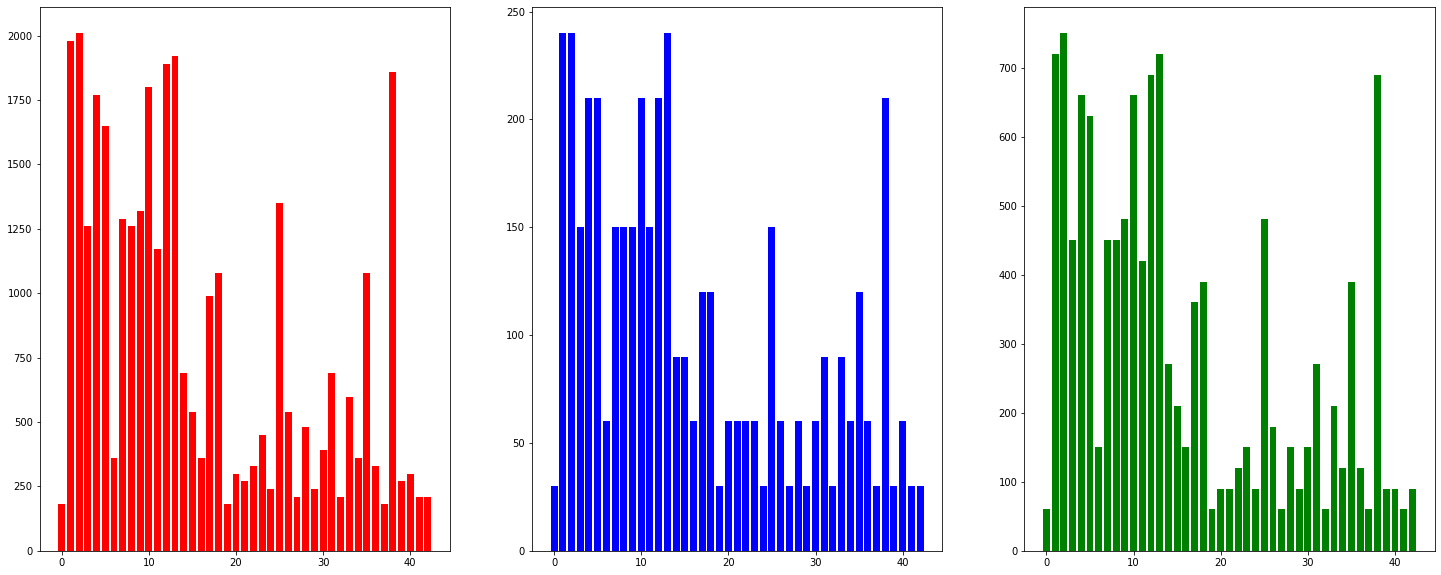

In [ ]:
test_frequencies[:, 0]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,10))
ax1.bar(train_frequencies[:,0], train_frequencies[:, 1], color='red')
ax2.bar(val_frequencies[:,0], val_frequencies[:, 1], color='blue')
ax3.bar(test_frequencies[:,0], test_frequencies[:, 1], color='green')

*Encontramos que existe un desbalance importante a lo largo de las 43 clases. Decidimos incorporar la opción de submuestrear estos datos en lugar de sobremuestrar debido a que ya existen suficientes observaciones en los tres conjuntos*

###1.3. Visualización

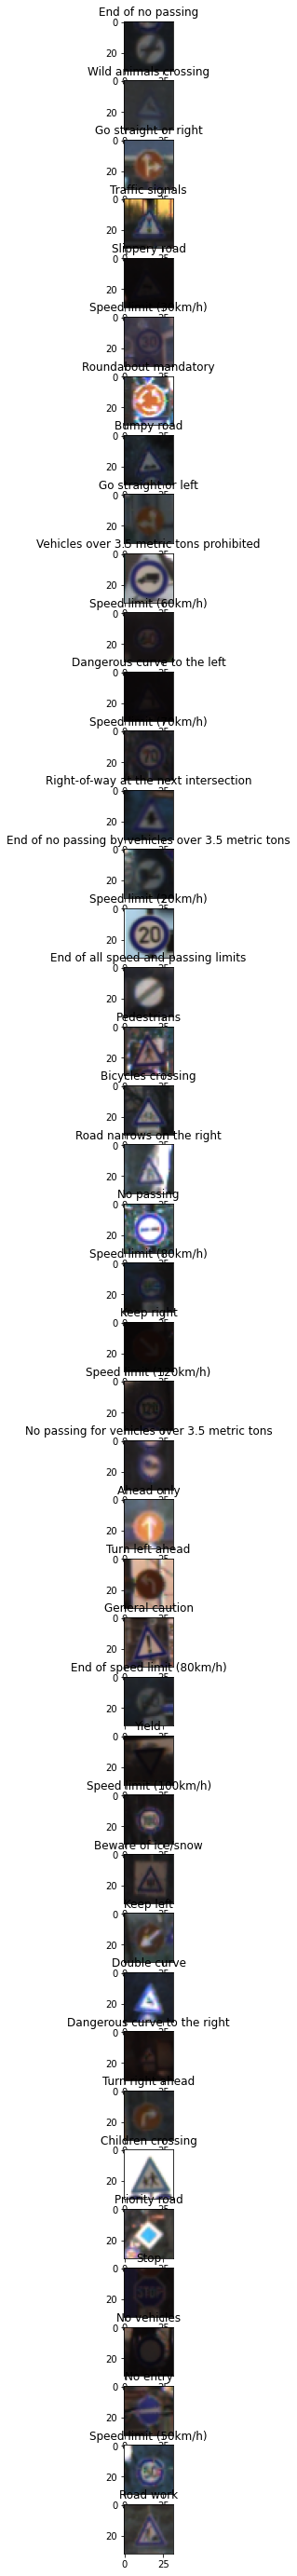

In [ ]:
sign_list= np.unique(train.get('labels')).tolist()

fig = plt.figure(figsize=(20,50))
fig.tight_layout(pad=3.0)

for i,v in enumerate(train.get('labels')):
  if(v in sign_list):
    sign_list.remove(v)
    img = train.get('features')[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    n = len(fig.axes)
    for i in range(n):
        fig.axes[i].change_geometry(n+1, 1, i+1)
    ax = fig.add_subplot(n+1, 1, n+1)
    ax.set_title(signnames.get(v))
    ax.imshow(img)
    


*Notamos que además de encontrarse pixeladas, muchas de estas imágenes presentan un contraste bajo por lo que propusimos dos métodos de ecualización: convencional y CLAHE (
Ecualización de histograma adaptativo de contraste limitado)*

#2 Procesamiento de datos

###2.1. Ecualización 

In [ ]:
#Imágenes muy oscuras necesidad de ecualizar
def equalize(image_src, with_plot=False, gray_scale=False):
    
    if not gray_scale:
        r_image, g_image, b_image = cv2.split(image_src)

        r_image_eq = cv2.equalizeHist(r_image)
        g_image_eq = cv2.equalizeHist(g_image)
        b_image_eq = cv2.equalizeHist(b_image)

        image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
        cmap_val = None
    else:
        image_eq = cv2.equalizeHist(image_src)
        cmap_val = 'gray'

    if with_plot:
        fig = plt.figure(figsize=(10, 20))

        ax1 = fig.add_subplot(2, 2, 1)
        ax1.axis("off")
        ax1.title.set_text('Original')
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.axis("off")
        ax2.title.set_text("Equalized")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_eq, cmap=cmap_val)
        return True
    return image_eq


def CLAHE(img):
    img_dtype = img.dtype

    img0 = img[..., 0]
    img1 = img[..., 1]
    img2 = img[..., 2]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

    cl0 = clahe.apply(img0)
    cl1 = clahe.apply(img1)
    cl2 = clahe.apply(img2)

    clahe_img = cv2.merge((cl0, cl1, cl2))

    clahe_img = clahe_img.astype(img_dtype)
    return clahe_img

Ecualización


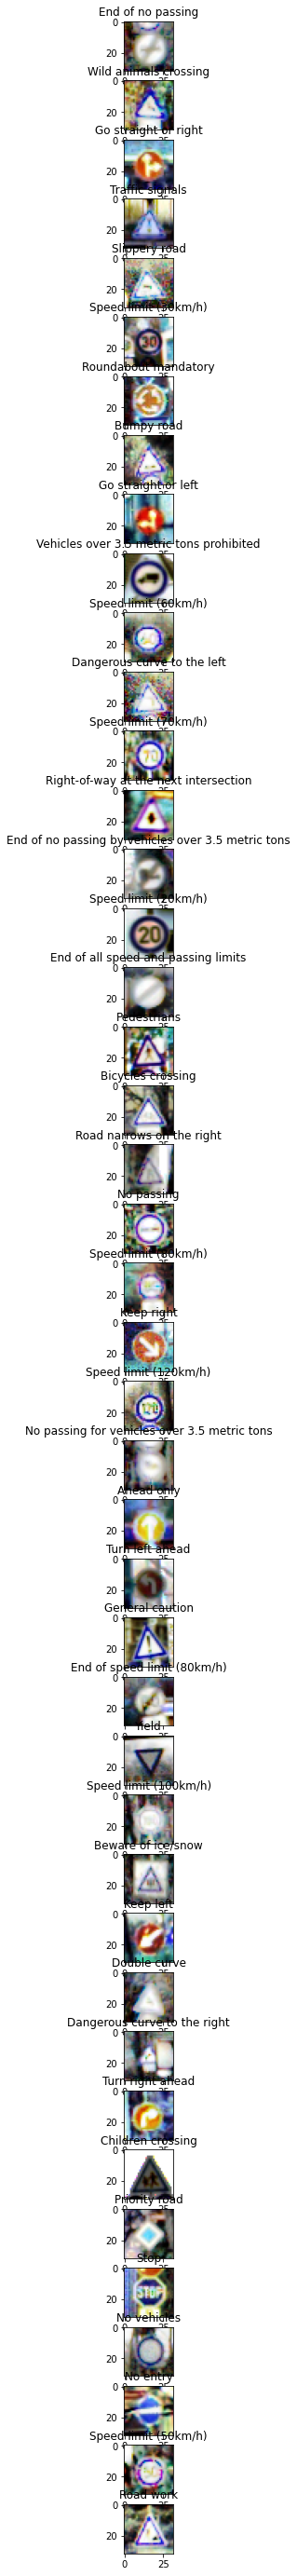

In [ ]:
sign_list= np.unique(train.get('labels')).tolist()

fig = plt.figure(figsize=(20,50))
fig.tight_layout(pad=3.0)

for i,v in enumerate(train.get('labels')):
  if(v in sign_list):
    sign_list.remove(v)
    img = train.get('features')[i]
    img = equalize(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    n = len(fig.axes)
    for i in range(n):
        fig.axes[i].change_geometry(n+1, 1, i+1)
    ax = fig.add_subplot(n+1, 1, n+1)
    ax.set_title(signnames.get(v))
    ax.imshow(img)

print('Ecualización')  


CLAHE


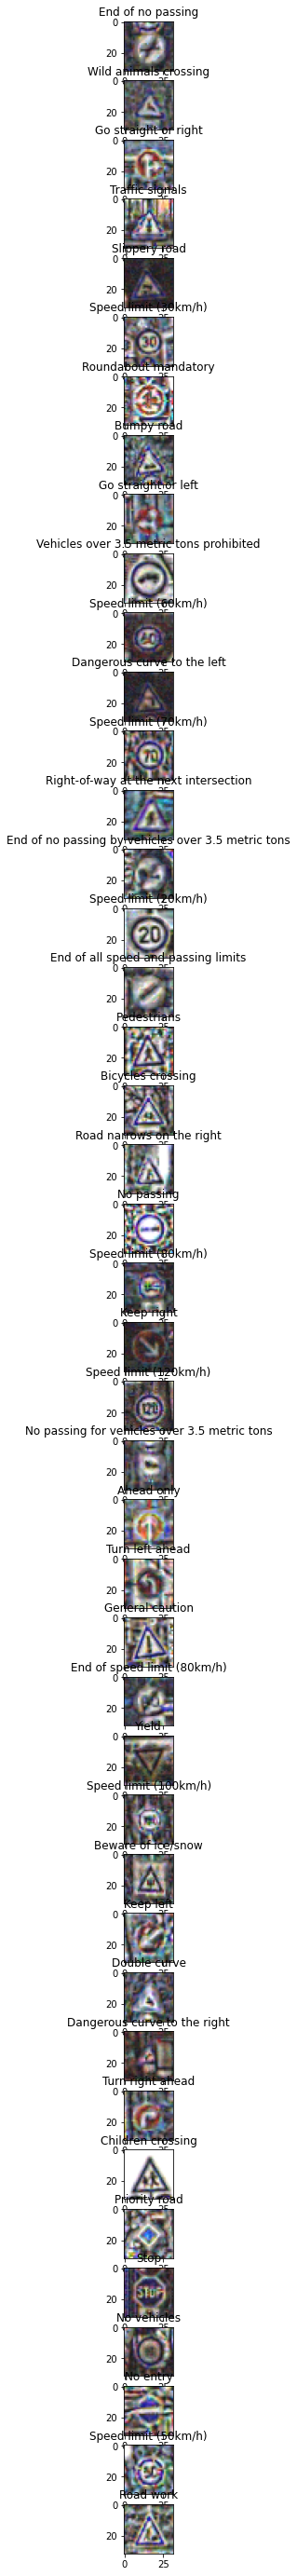

In [ ]:
sign_list= np.unique(train.get('labels')).tolist()

fig = plt.figure(figsize=(20,50))
fig.tight_layout(pad=3.0)

for i,v in enumerate(train.get('labels')):
  if(v in sign_list):
    sign_list.remove(v)
    img = train.get('features')[i]
    img = CLAHE(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    n = len(fig.axes)
    for i in range(n):
        fig.axes[i].change_geometry(n+1, 1, i+1)
    ax = fig.add_subplot(n+1, 1, n+1)
    ax.set_title(signnames.get(v))
    ax.imshow(img)
    
print('CLAHE')

In [ ]:
#Función para ecualizar conjunto
def equalize_sets(features):
  for i in range(len(features)):
    if (features.shape==4):
      gray=False
      features[i] = equalize(features[i], gray_scale=gray)
    if (features.shape==3):
      gray=True
      features[i] = equalize(features[i], gray_scale=gray)
  return features

#Función para aplicar CLAHE en un conjunto
def CLAHE_sets(features):
  for i in range(len(features)):
    features[i] = CLAHE(features[i])
  return features

*Debido a que con CLAHE las imágenes parecieran distorsionarse o volverse ruidosas, optamos por utilizar ecualización tradicional*

### 2.2. Submuestreo aleatorio

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

#Función para balancear clases mendiante el submuestreo a cantidad de observaciones de clase minoritaria
def undersampling(features, labels):
  undersample = RandomUnderSampler(sampling_strategy='all')
  if(len(features.shape)==4):
    X, y = undersample.fit_resample(features.reshape(len(features),features.shape[1]*features.shape[2]*features.shape[3]), labels)
    X = X.reshape(len(X),features.shape[1],features.shape[2],features.shape[3])
  if(len(features.shape)==3):
    X, y = undersample.fit_resample(features.reshape(len(features),features.shape[1]*features.shape[2]), labels)
    X = X.reshape(len(X),features.shape[1],features.shape[2])
  return X,y


*Incoporamos una función para aplicar experimentos con submuestreo y de esta forma balancear todas las clases para que posean la misma cantidad de observaciones que la clase menos representada (clase minoritaria) en el conjunto*

###2.3. Conversión a gris eliminar

In [ ]:
def color_to_gray(X_color):
  X_gray =[]
  for i in range(len(X_color)):
    gray = cv2.cvtColor(X_color[i], cv2.COLOR_BGR2GRAY)
    X_gray.append(gray)
  return np.array(X_gray)

*Incorporamos una función para convertir las imágenes a escala de gris y evaluar si la disminución en la cantidad de canales tiene un impacto no sólo en el desempeño del clasificador sino también en los tiempos de entrenamiento*

###2.4 Normalización

In [ ]:
def normalize(X):
  X = X.astype('float32')/255
  return X

#3 Extracción de features (Autoencoders)

In [ ]:
#funciones accesorias
def flatten_features(X):
  X_flat = []
  for i in range(len(X)):
    X_flat.append(X[i].flatten())

  return np.array(X_flat)

def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

    
def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

In [ ]:
#Construcción del Autoencoder
def general_ae(input_size, latent_size):
    input = Input(input_size)
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    
    #Middle
    middle = create_block(x, latent_size)
    
    # Decoder
    up1 = UpSampling2D((2,2))(middle)
    block3 = create_block(up1, 64)
    #up1 = UpSampling2D((2,2))(block3)
    up2 = UpSampling2D((2,2))(block3)
    block4 = create_block(up2, 32)
    #up2 = UpSampling2D((2,2))(block4)
    
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)


In [ ]:
#Ajuste o entrenamiento del Autoencoder
def adjust_ae(X_train, X_val, input_size, latent_size):
  encoder_ae, model_ae = general_ae(input_size,latent_size)
  model_ae.compile(SGD(1e-3, 0.9), loss=loss_function)
  er = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.0001)
  callbacks = [er, lr]
  history = model_ae.fit(X_train, X_train, 
                        batch_size=512,
                        epochs=100,
                        verbose=1,
                        validation_data=(X_val, X_val),
                        shuffle=True, callbacks=callbacks)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

  return encoder_ae, model_ae

In [ ]:
#Función para visualizar imágenes originales y reconstruidas mediante el Autoencoder
import random
def plot_reconstructions(original, reconstructed, num=10):  
    n = num
    plt.figure(figsize=(20, 4))
    index = random.sample(np.arange(len(original)).tolist(), 10)

    for i in range(n):
        idx = index[i]
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[idx].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(reconstructed[idx].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


#4 Selección de features (ExtraTreesClassifier)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
#Ajuste de un ExtraTreesClassifier para evaluar importancia de features
#Se seleccionan todas features cuya "importancia" sea superior a la media de las "importancias"

def select_features(X,y, Xval, Xtest):
  model = ExtraTreesClassifier(n_estimators=10)
  model.fit(X,y)
  importance = model.feature_importances_
  selected_features = []
  selected_features_v = []
  selected_features_t = []
  
  for i in range(len(importance)):
    if(importance[i]>=np.mean(importance)):
      selected_features.append(X[:,i])
      selected_features_v.append(Xval[:,i])
      selected_features_t.append(Xtest[:,i])

  selected_features = np.array(selected_features).reshape(len(X), len(selected_features))
  selected_features_v = np.array(selected_features_v).reshape(len(Xval), len(selected_features_v))
  selected_features_t = np.array(selected_features_t).reshape(len(Xtest), len(selected_features_t))

  return selected_features, selected_features_v, selected_features_t

#5 Clasificación (MLP)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
#Función para obtener el reporte de clasificación y matriz de confusión
def get_metrics(ytrue, ypred):
  print(classification_report(ytrue, ypred))
  cf_matrix = confusion_matrix(ytrue, ypred)
  fig, ax = plt.subplots(figsize=(50,50))
  sns.heatmap(cf_matrix, annot=True, ax=ax)

###5.1. Pipeline de preprocesamiento común

In [ ]:
#Features originales (todas las observaciones)
X_train, y_train = train.get('features'), train.get('labels')
X_val, y_val = val.get('features'), val.get('labels')
X_test, y_test = test.get('features'), test.get('labels')

#Conversión gris
X_train_g = color_to_gray(X_train)
X_val_g = color_to_gray(X_val)
X_test_g = color_to_gray(X_test)

#Ecualización (color y gris)
X_train = equalize_sets(X_train)
X_val = equalize_sets(X_val)
X_test = equalize_sets(X_test)

X_train_g = equalize_sets(X_train_g)
X_val_g = equalize_sets(X_val_g)
X_test_g = equalize_sets(X_test_g)

#Normalizacion (color y gris)
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

X_train_g = normalize(X_train_g)
X_val_g = normalize(X_val_g)
X_test_g = normalize(X_test_g)

In [ ]:
X_train.shape, X_train_g.shape

((34799, 32, 32, 3), (34799, 32, 32))

In [ ]:
X_train_g = np.reshape(X_train_g, (len(X_train_g),X_train_g.shape[1], X_train_g.shape[2], 1))
X_val_g = np.reshape(X_val_g, (len(X_val_g),X_val_g.shape[1], X_val_g.shape[2], 1))
X_test_g = np.reshape(X_test_g, (len(X_test_g),X_test_g.shape[1], X_test_g.shape[2], 1))

X_train_g.shape

(34799, 32, 32, 1)

###5.2 Experimentos

#### A. Raw pixels (imagen color)


*   Imagen color (3 canales)
*   Todas las observaciones
*   Todas las features (raw pixels)




In [ ]:
#Flatten features
Xtr = flatten_features(X_train)
Xval = flatten_features(X_val)
Xte = flatten_features(X_test)

Xtr.shape, Xval.shape, Xte.shape

((34799, 3072), (4410, 3072), (12630, 3072))

In [ ]:
mlp = MLPClassifier().fit(Xtr, y_train)

Resultados en set de Validación
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        30
           1       0.79      0.90      0.85       240
           2       0.88      0.67      0.76       240
           3       0.71      0.98      0.83       150
           4       0.81      0.97      0.88       210
           5       0.84      0.84      0.84       210
           6       0.78      0.98      0.87        60
           7       0.92      0.80      0.85       150
           8       0.88      0.84      0.86       150
           9       0.97      0.88      0.92       150
          10       0.98      0.99      0.98       210
          11       0.95      0.81      0.88       150
          12       1.00      1.00      1.00       210
          13       0.98      0.98      0.98       240
          14       0.98      0.93      0.95        90
          15       0.98      0.93      0.95        90
          16       1.00      0.98      0.99      

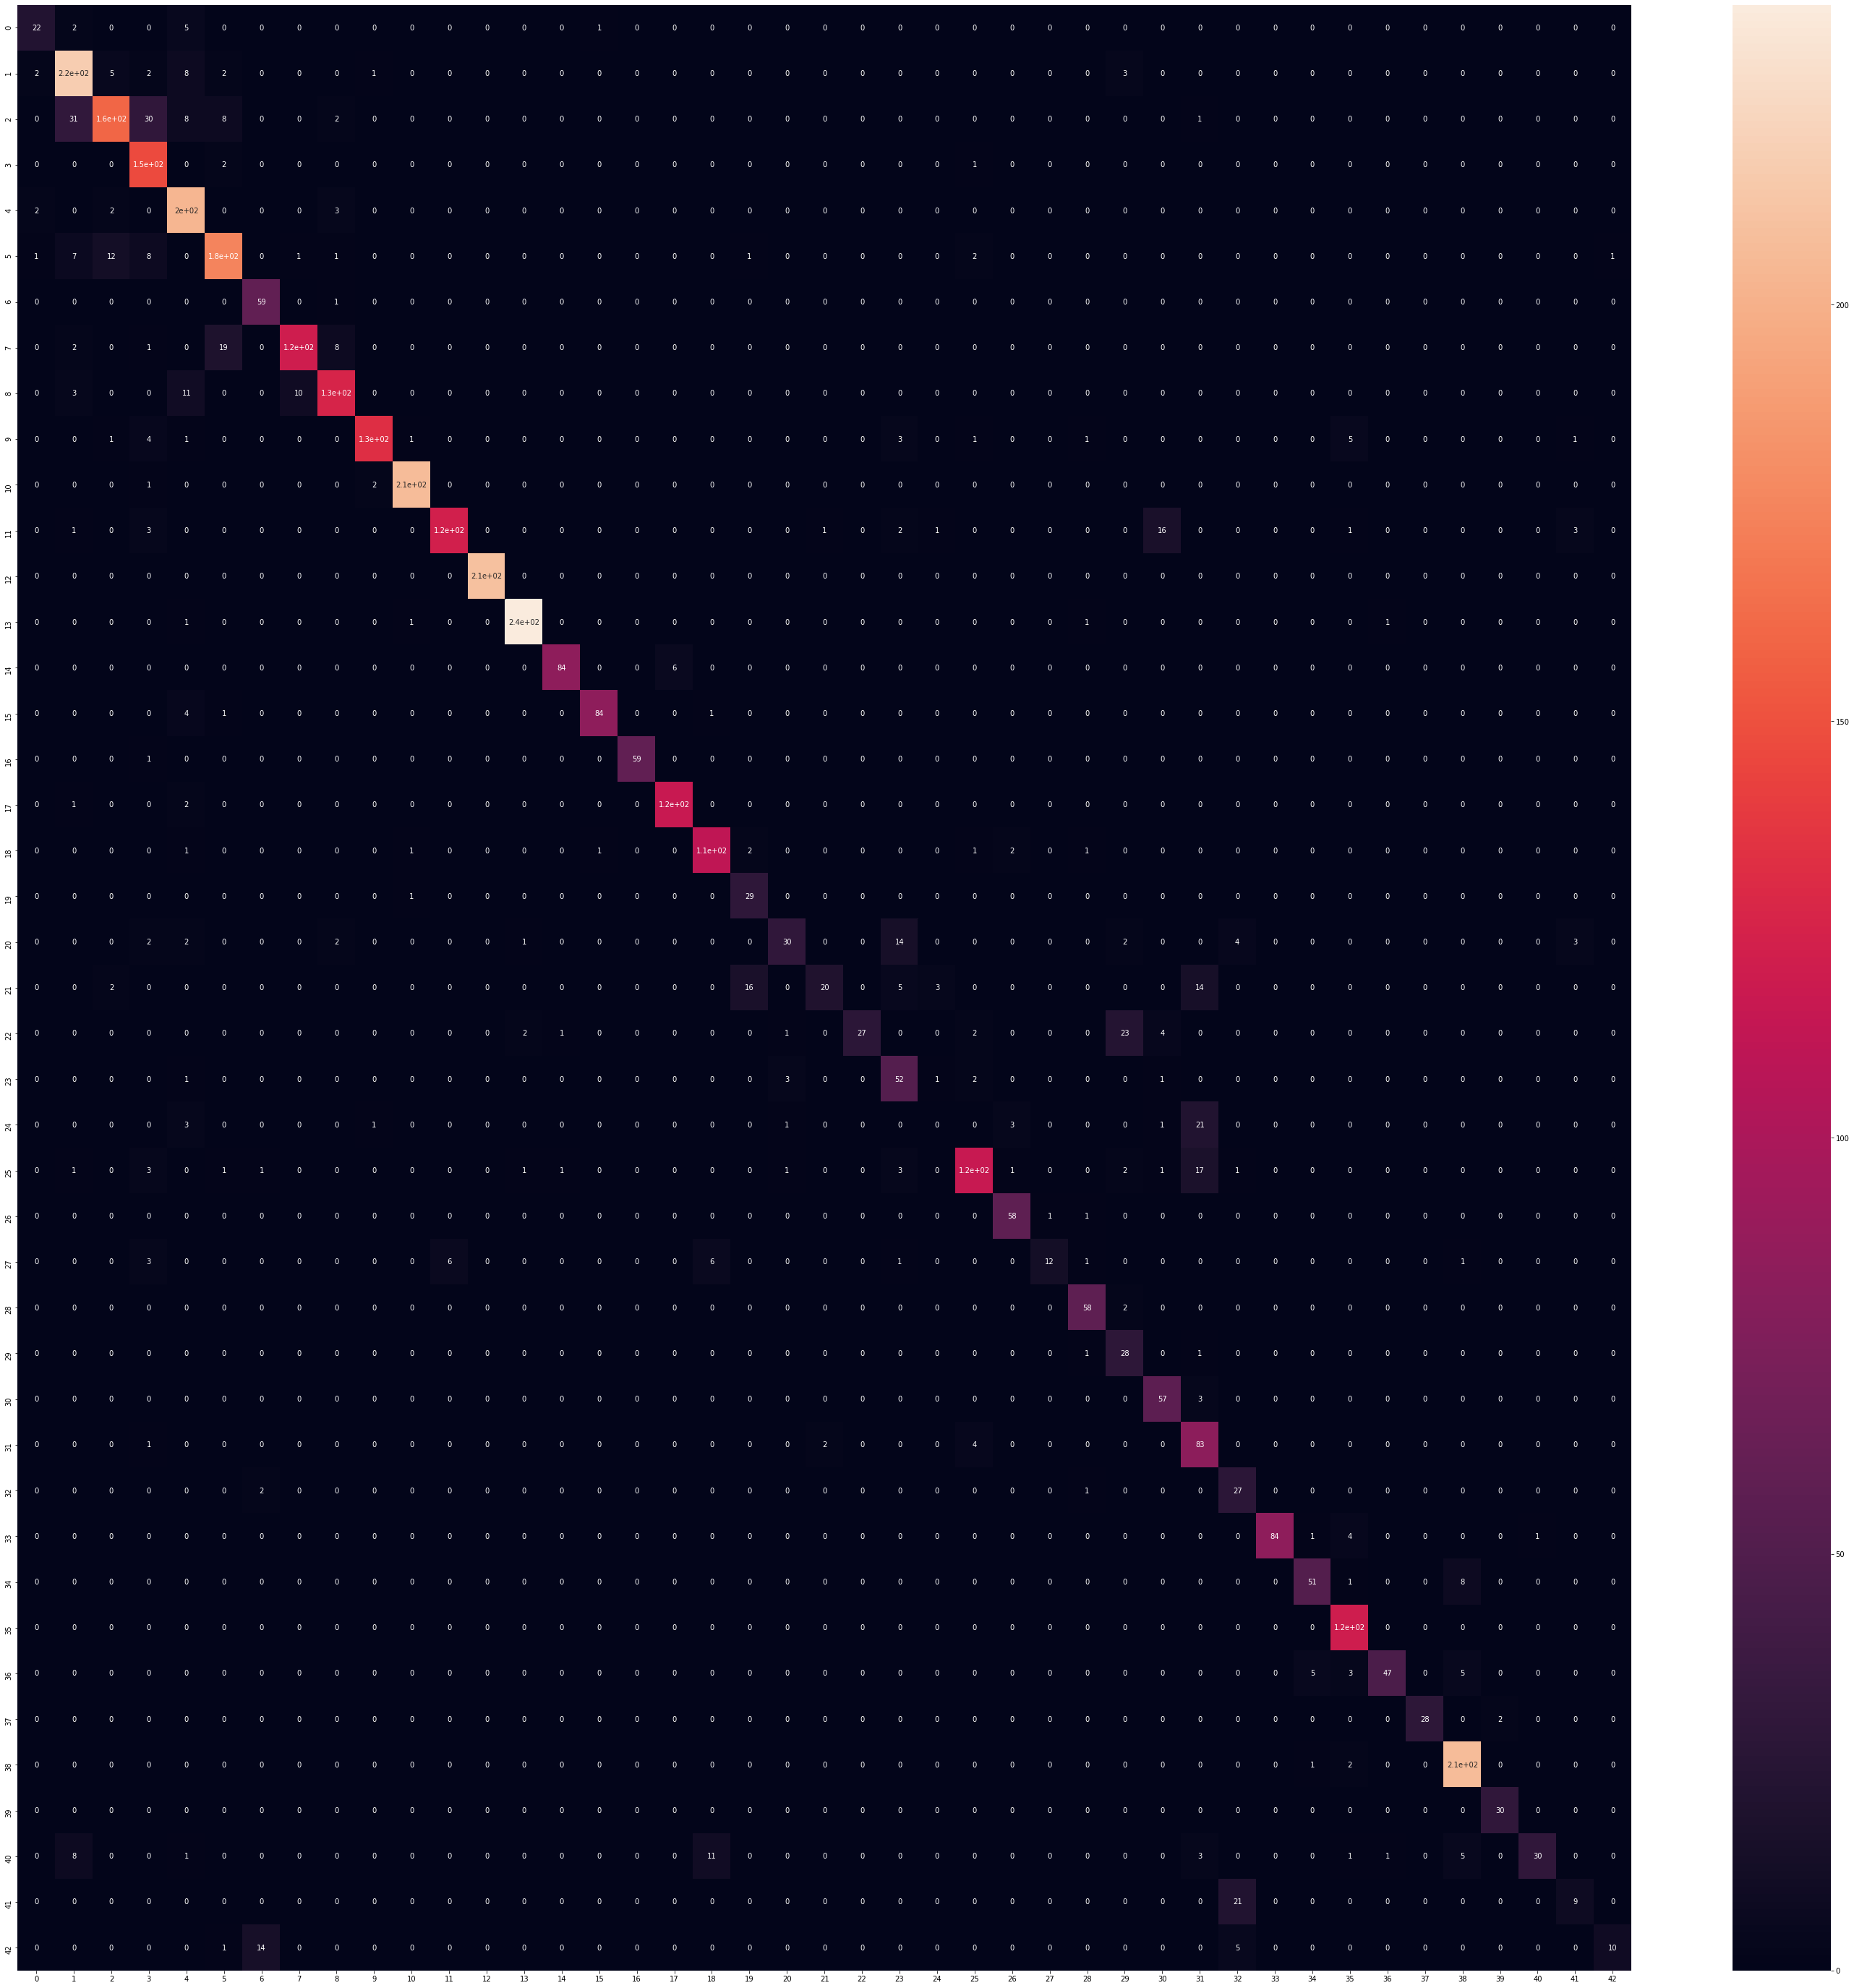

In [ ]:
print('Resultados en set de Validación')
ypred = mlp.predict(Xval)
get_metrics(y_val, ypred)

Resultados en set de Test
              precision    recall  f1-score   support

           0       0.36      0.33      0.35        60
           1       0.77      0.87      0.81       720
           2       0.91      0.85      0.88       750
           3       0.66      0.94      0.78       450
           4       0.78      0.87      0.82       660
           5       0.80      0.86      0.83       630
           6       0.77      0.69      0.73       150
           7       0.89      0.70      0.78       450
           8       0.88      0.85      0.87       450
           9       0.97      0.89      0.93       480
          10       0.95      0.96      0.96       660
          11       0.94      0.81      0.87       420
          12       0.98      0.91      0.95       690
          13       0.98      0.97      0.97       720
          14       0.99      0.98      0.99       270
          15       0.85      0.90      0.88       210
          16       0.97      0.97      0.97       150
 

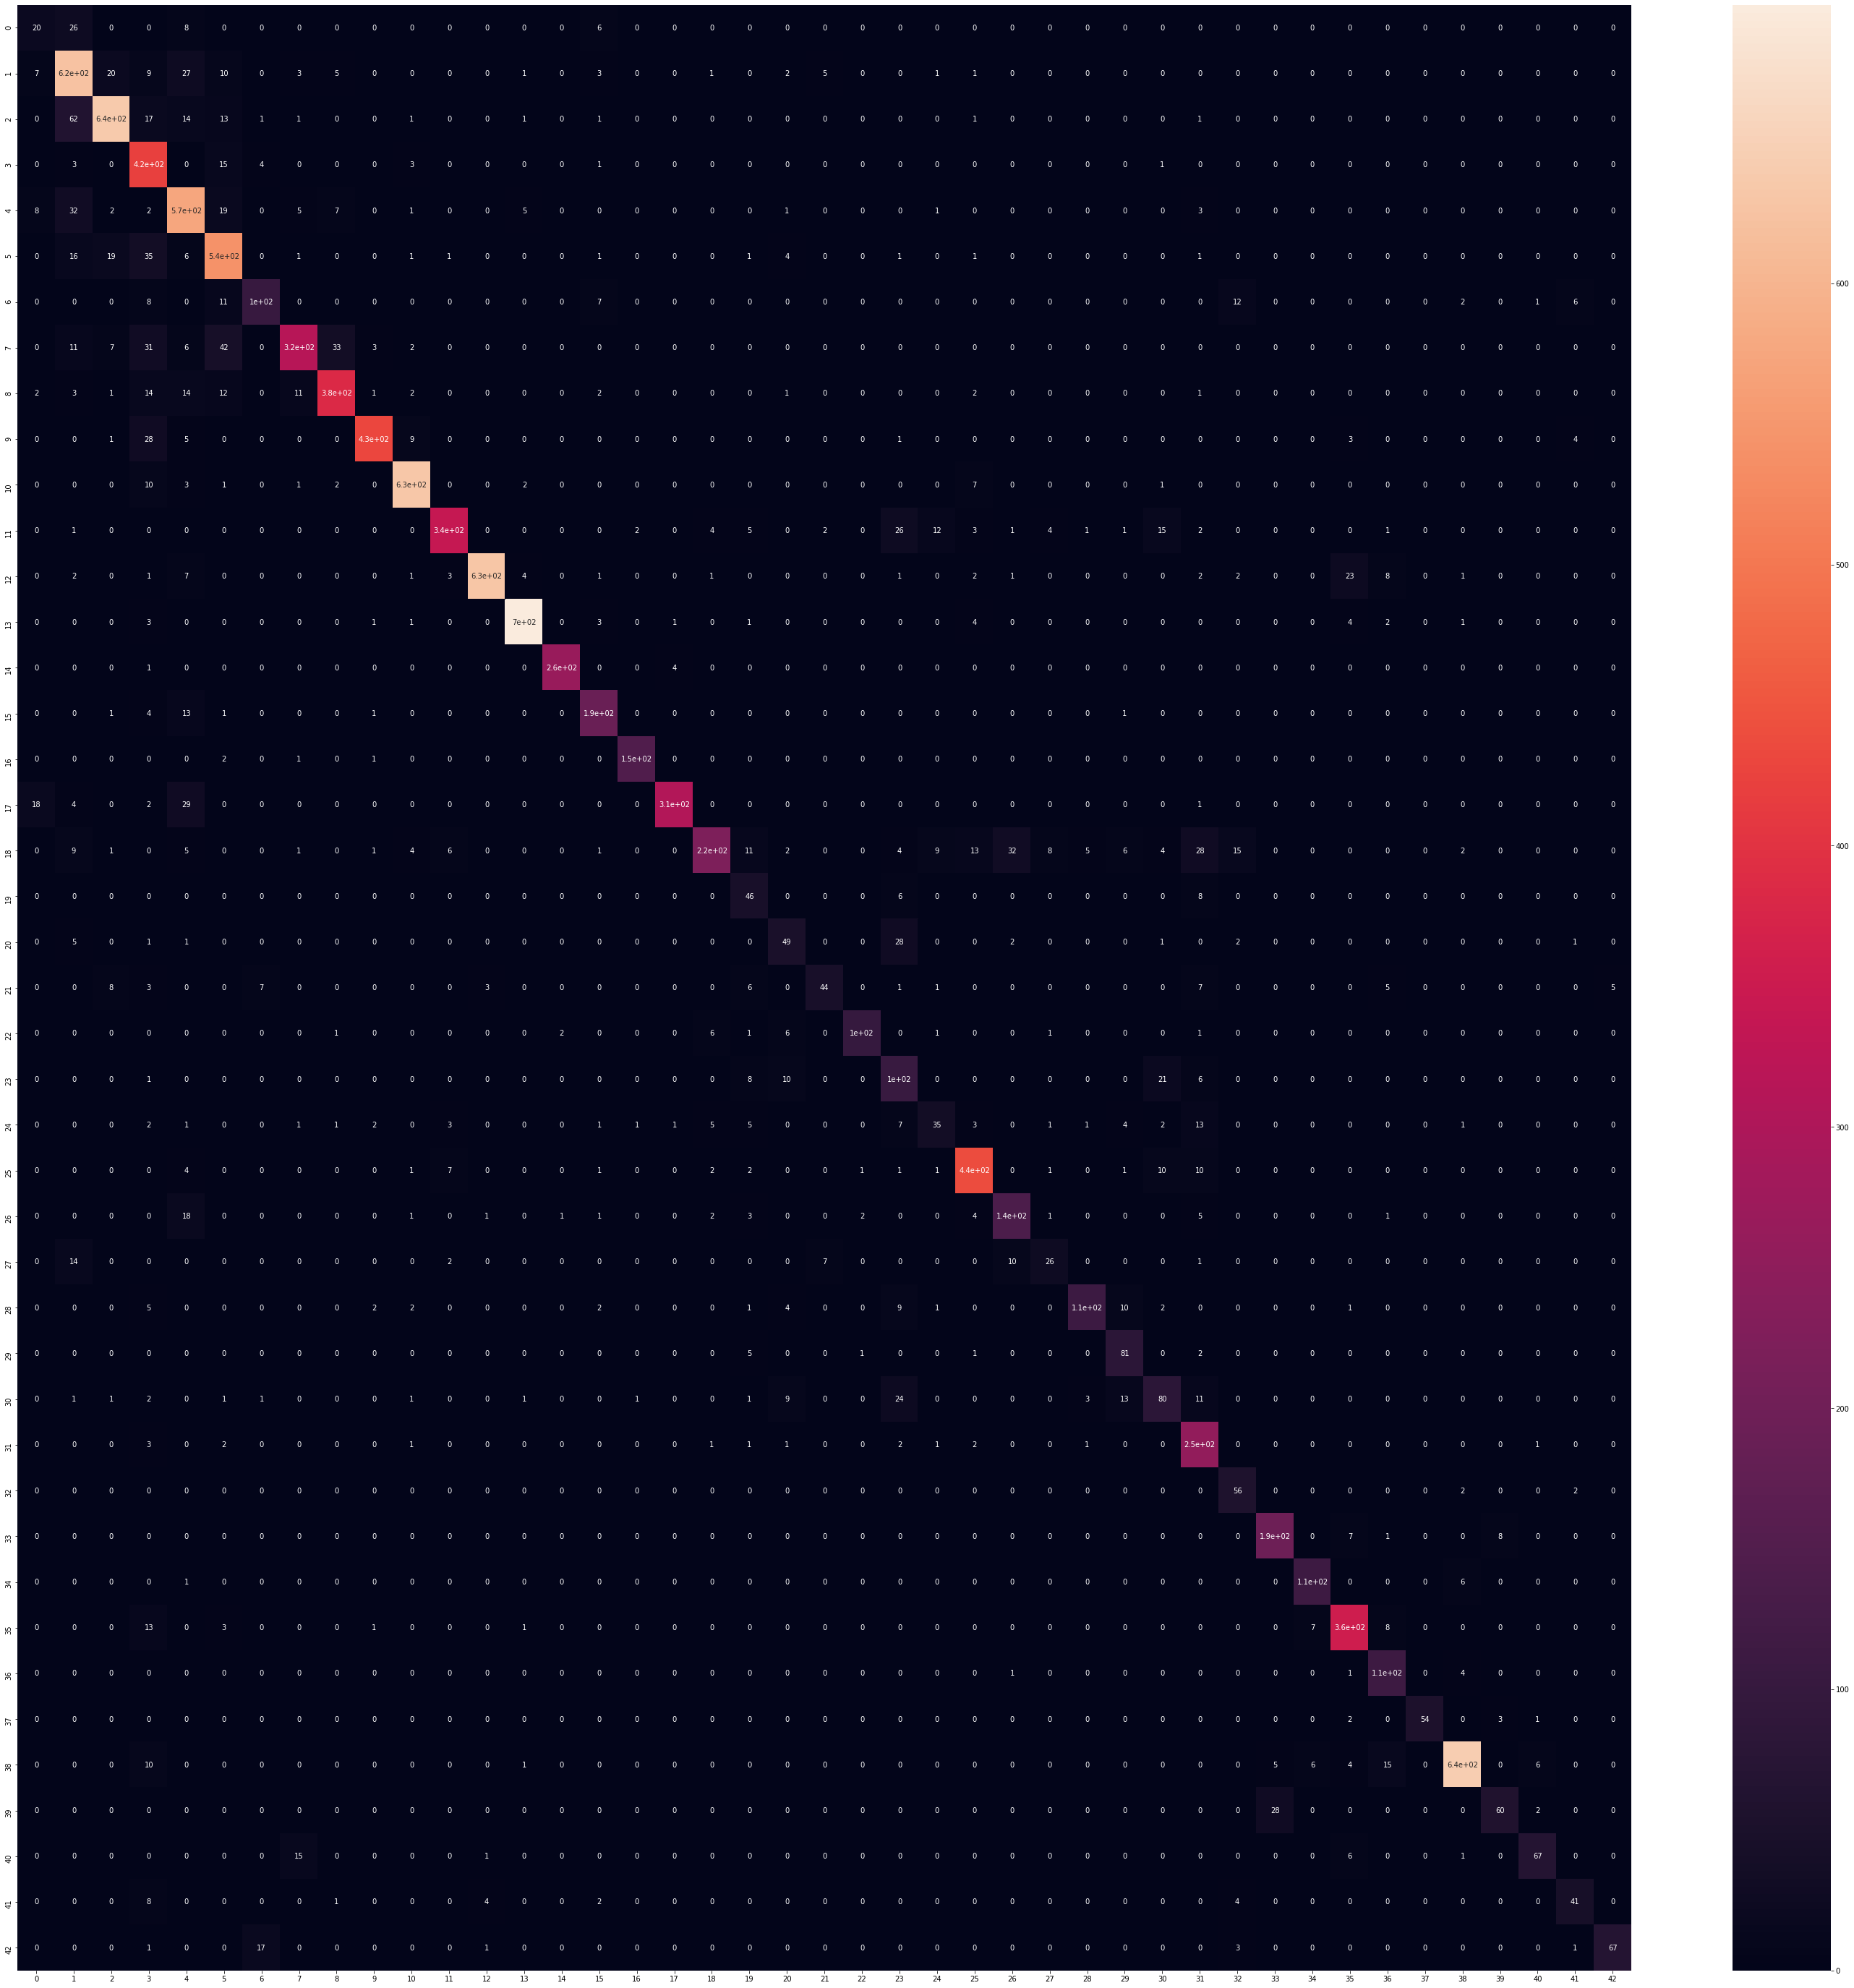

In [ ]:
print('Resultados en set de Test')
ypred = mlp.predict(Xte)
get_metrics(y_test, ypred)

*Primera aproximación con imágenes a color, empleando todos los píxeles de todos los canales y todas las observaciones arrojó buenos resultados en validación y testeo (exactitud balanceada > 0.5) empleando la configuración por default del Perceptrón Multicapa. En los próximos experimentos buscaremos de diversas formas disminuir la cantidad de observaciones y/o features mediante distintos métodos y evaluaremos cómo se modifica la performance. De esta manera, veremos si la disminución en el costo computacional durante entrenamiento/inferencia es conveniente o si esto provoca una caída en la performance inaceptable.*

#### B. Raw pixels (imagen gris)

*   Imagen gris (1 canal)
*   Todas las observaciones
*   Todas las features (raw pixels)

In [ ]:
#Flatten features
Xtr = flatten_features(X_train_g)
Xval = flatten_features(X_val_g)
Xte = flatten_features(X_test_g)

Xtr.shape, Xval.shape, Xte.shape

((34799, 1024), (4410, 1024), (12630, 1024))

In [ ]:
mlp = MLPClassifier().fit(Xtr, y_train)

Resultados en set de Validación
              precision    recall  f1-score   support

           0       0.60      0.40      0.48        30
           1       0.80      0.89      0.84       240
           2       0.76      0.80      0.78       240
           3       0.78      0.85      0.81       150
           4       0.90      0.91      0.91       210
           5       0.84      0.82      0.83       210
           6       0.89      0.97      0.93        60
           7       0.89      0.81      0.85       150
           8       0.79      0.88      0.83       150
           9       0.94      0.93      0.94       150
          10       0.97      0.99      0.98       210
          11       0.78      0.97      0.87       150
          12       0.79      0.94      0.86       210
          13       0.96      0.98      0.97       240
          14       0.91      0.92      0.92        90
          15       0.84      0.79      0.81        90
          16       0.98      1.00      0.99      

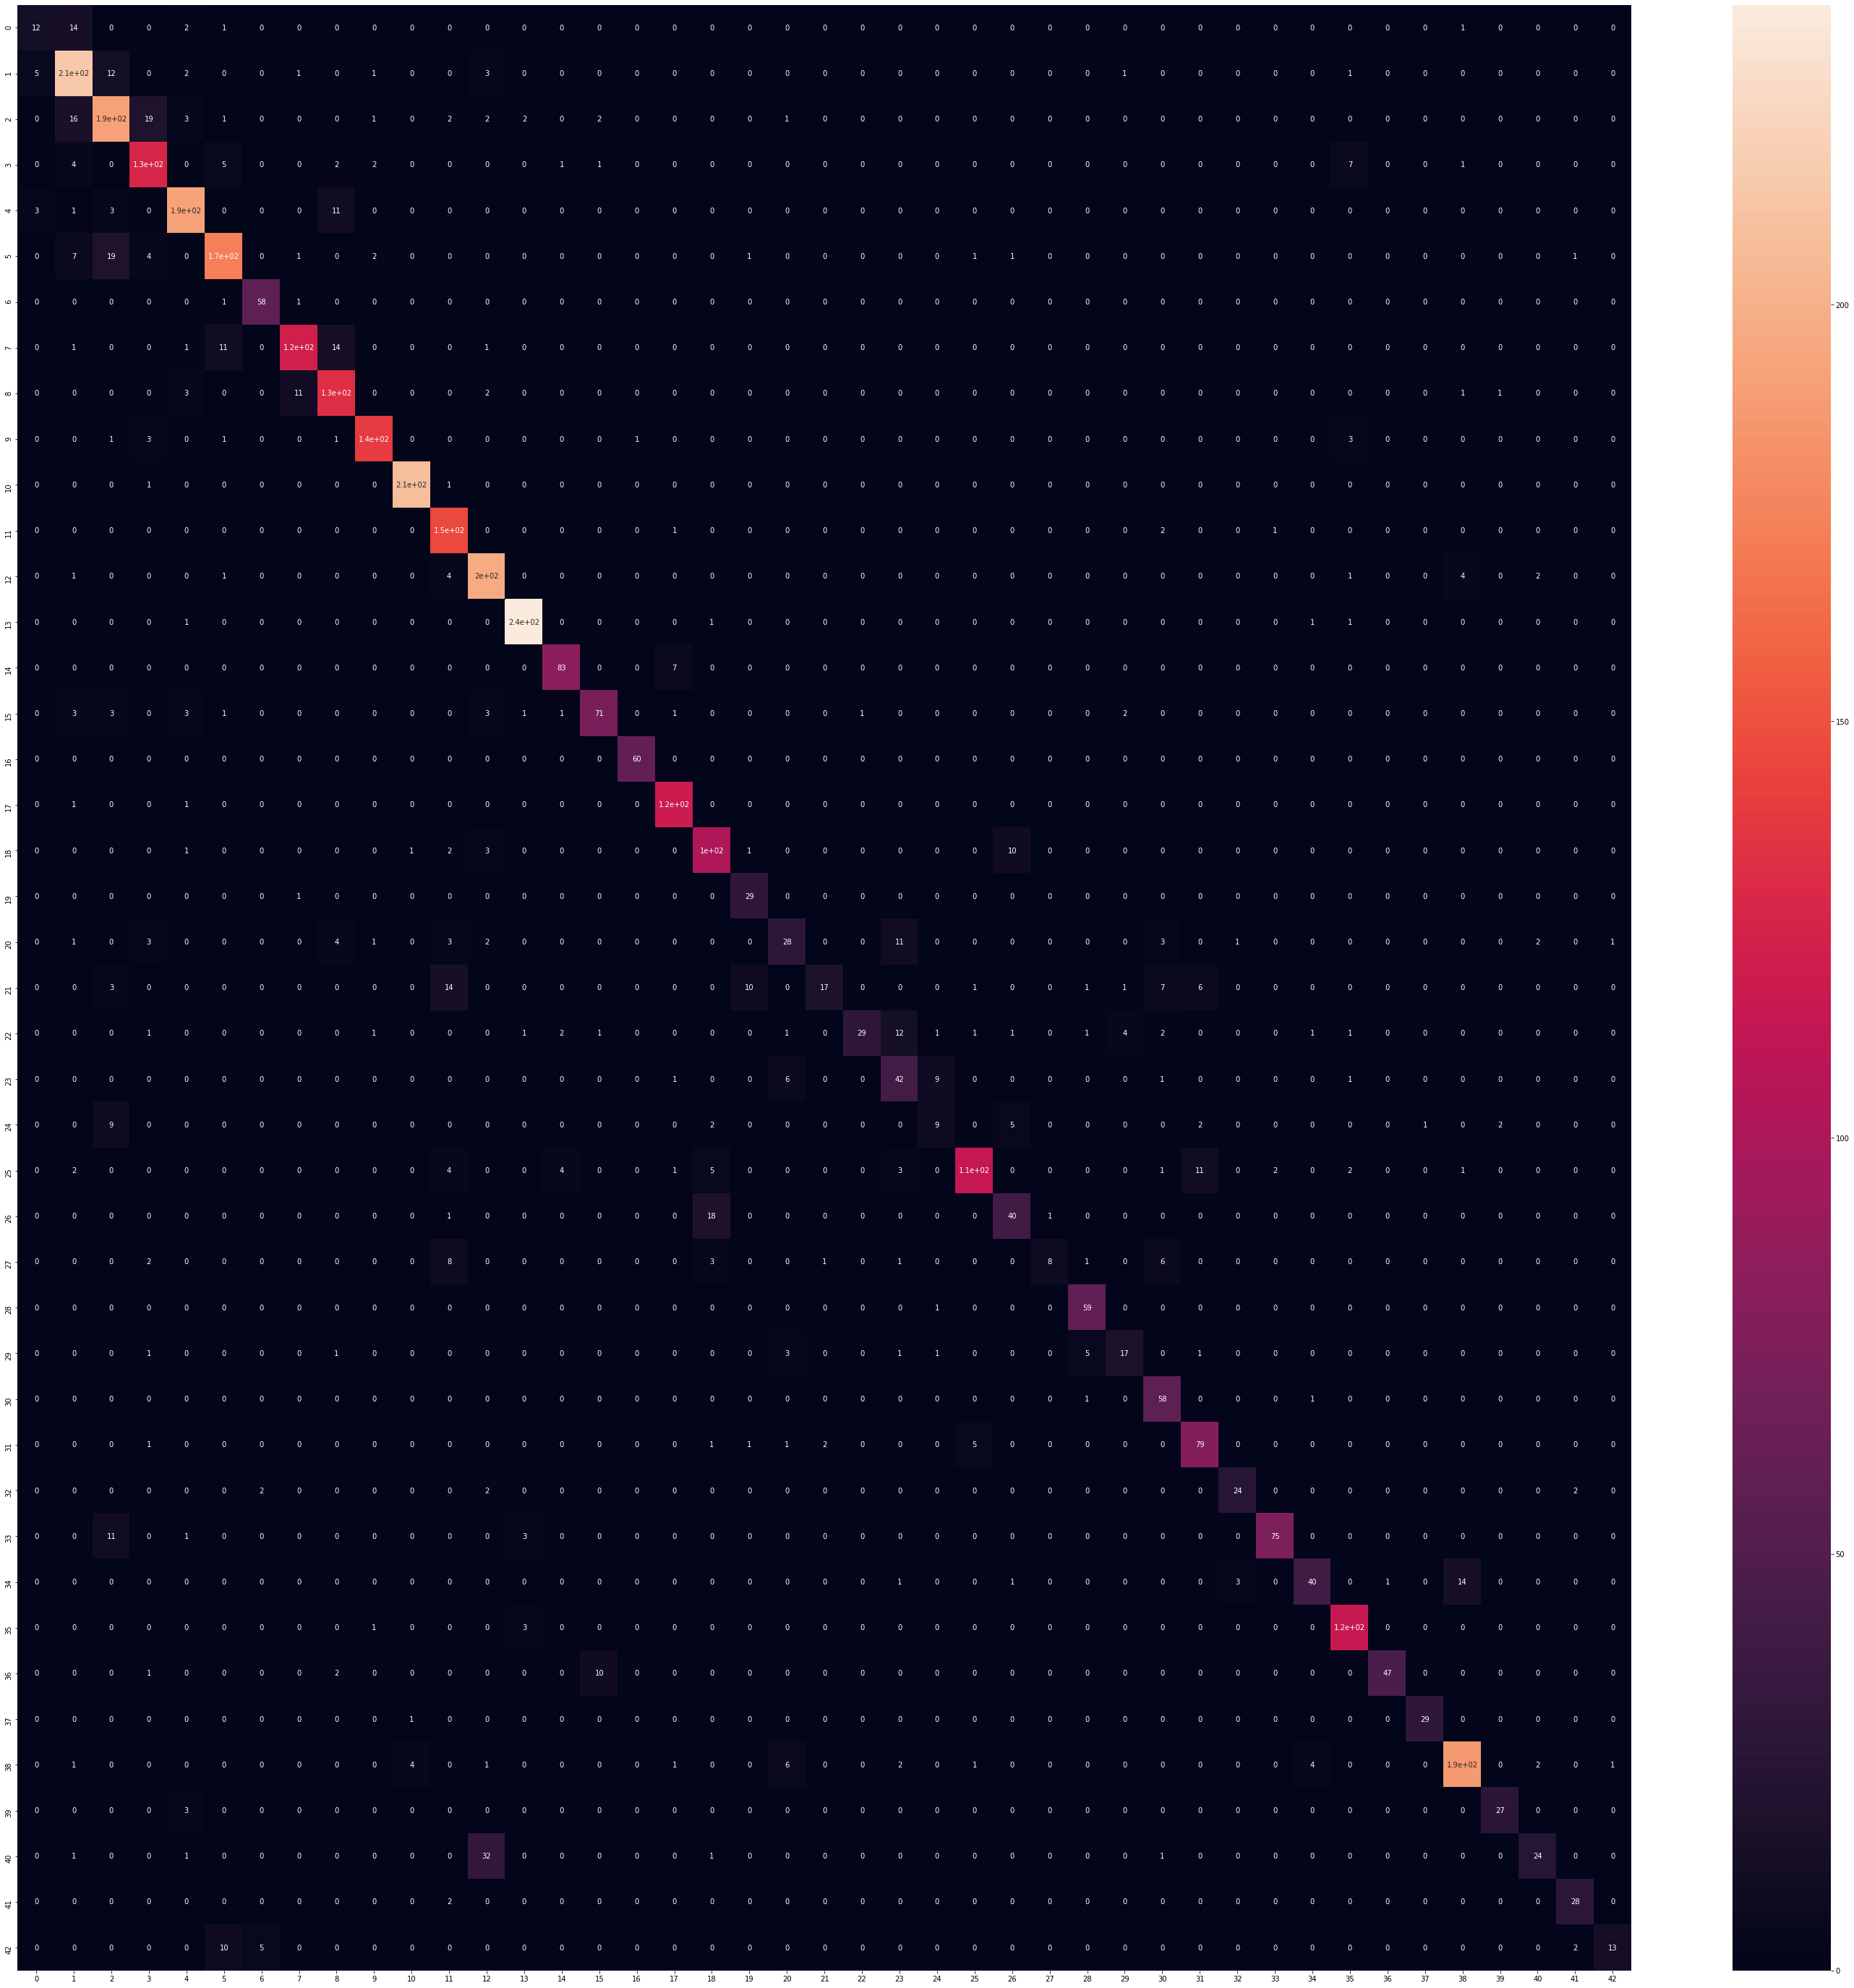

In [ ]:
print('Resultados en set de Validación')
ypred = mlp.predict(Xval)
get_metrics(y_val, ypred)

Resultados en set de Test
              precision    recall  f1-score   support

           0       0.47      0.33      0.39        60
           1       0.75      0.88      0.81       720
           2       0.84      0.91      0.87       750
           3       0.72      0.91      0.80       450
           4       0.90      0.84      0.87       660
           5       0.85      0.83      0.84       630
           6       0.94      0.69      0.79       150
           7       0.91      0.73      0.81       450
           8       0.84      0.87      0.85       450
           9       0.91      0.91      0.91       480
          10       0.91      0.95      0.93       660
          11       0.78      0.90      0.83       420
          12       0.84      0.92      0.88       690
          13       0.94      0.97      0.95       720
          14       0.92      0.92      0.92       270
          15       0.89      0.85      0.87       210
          16       0.95      0.97      0.96       150
 

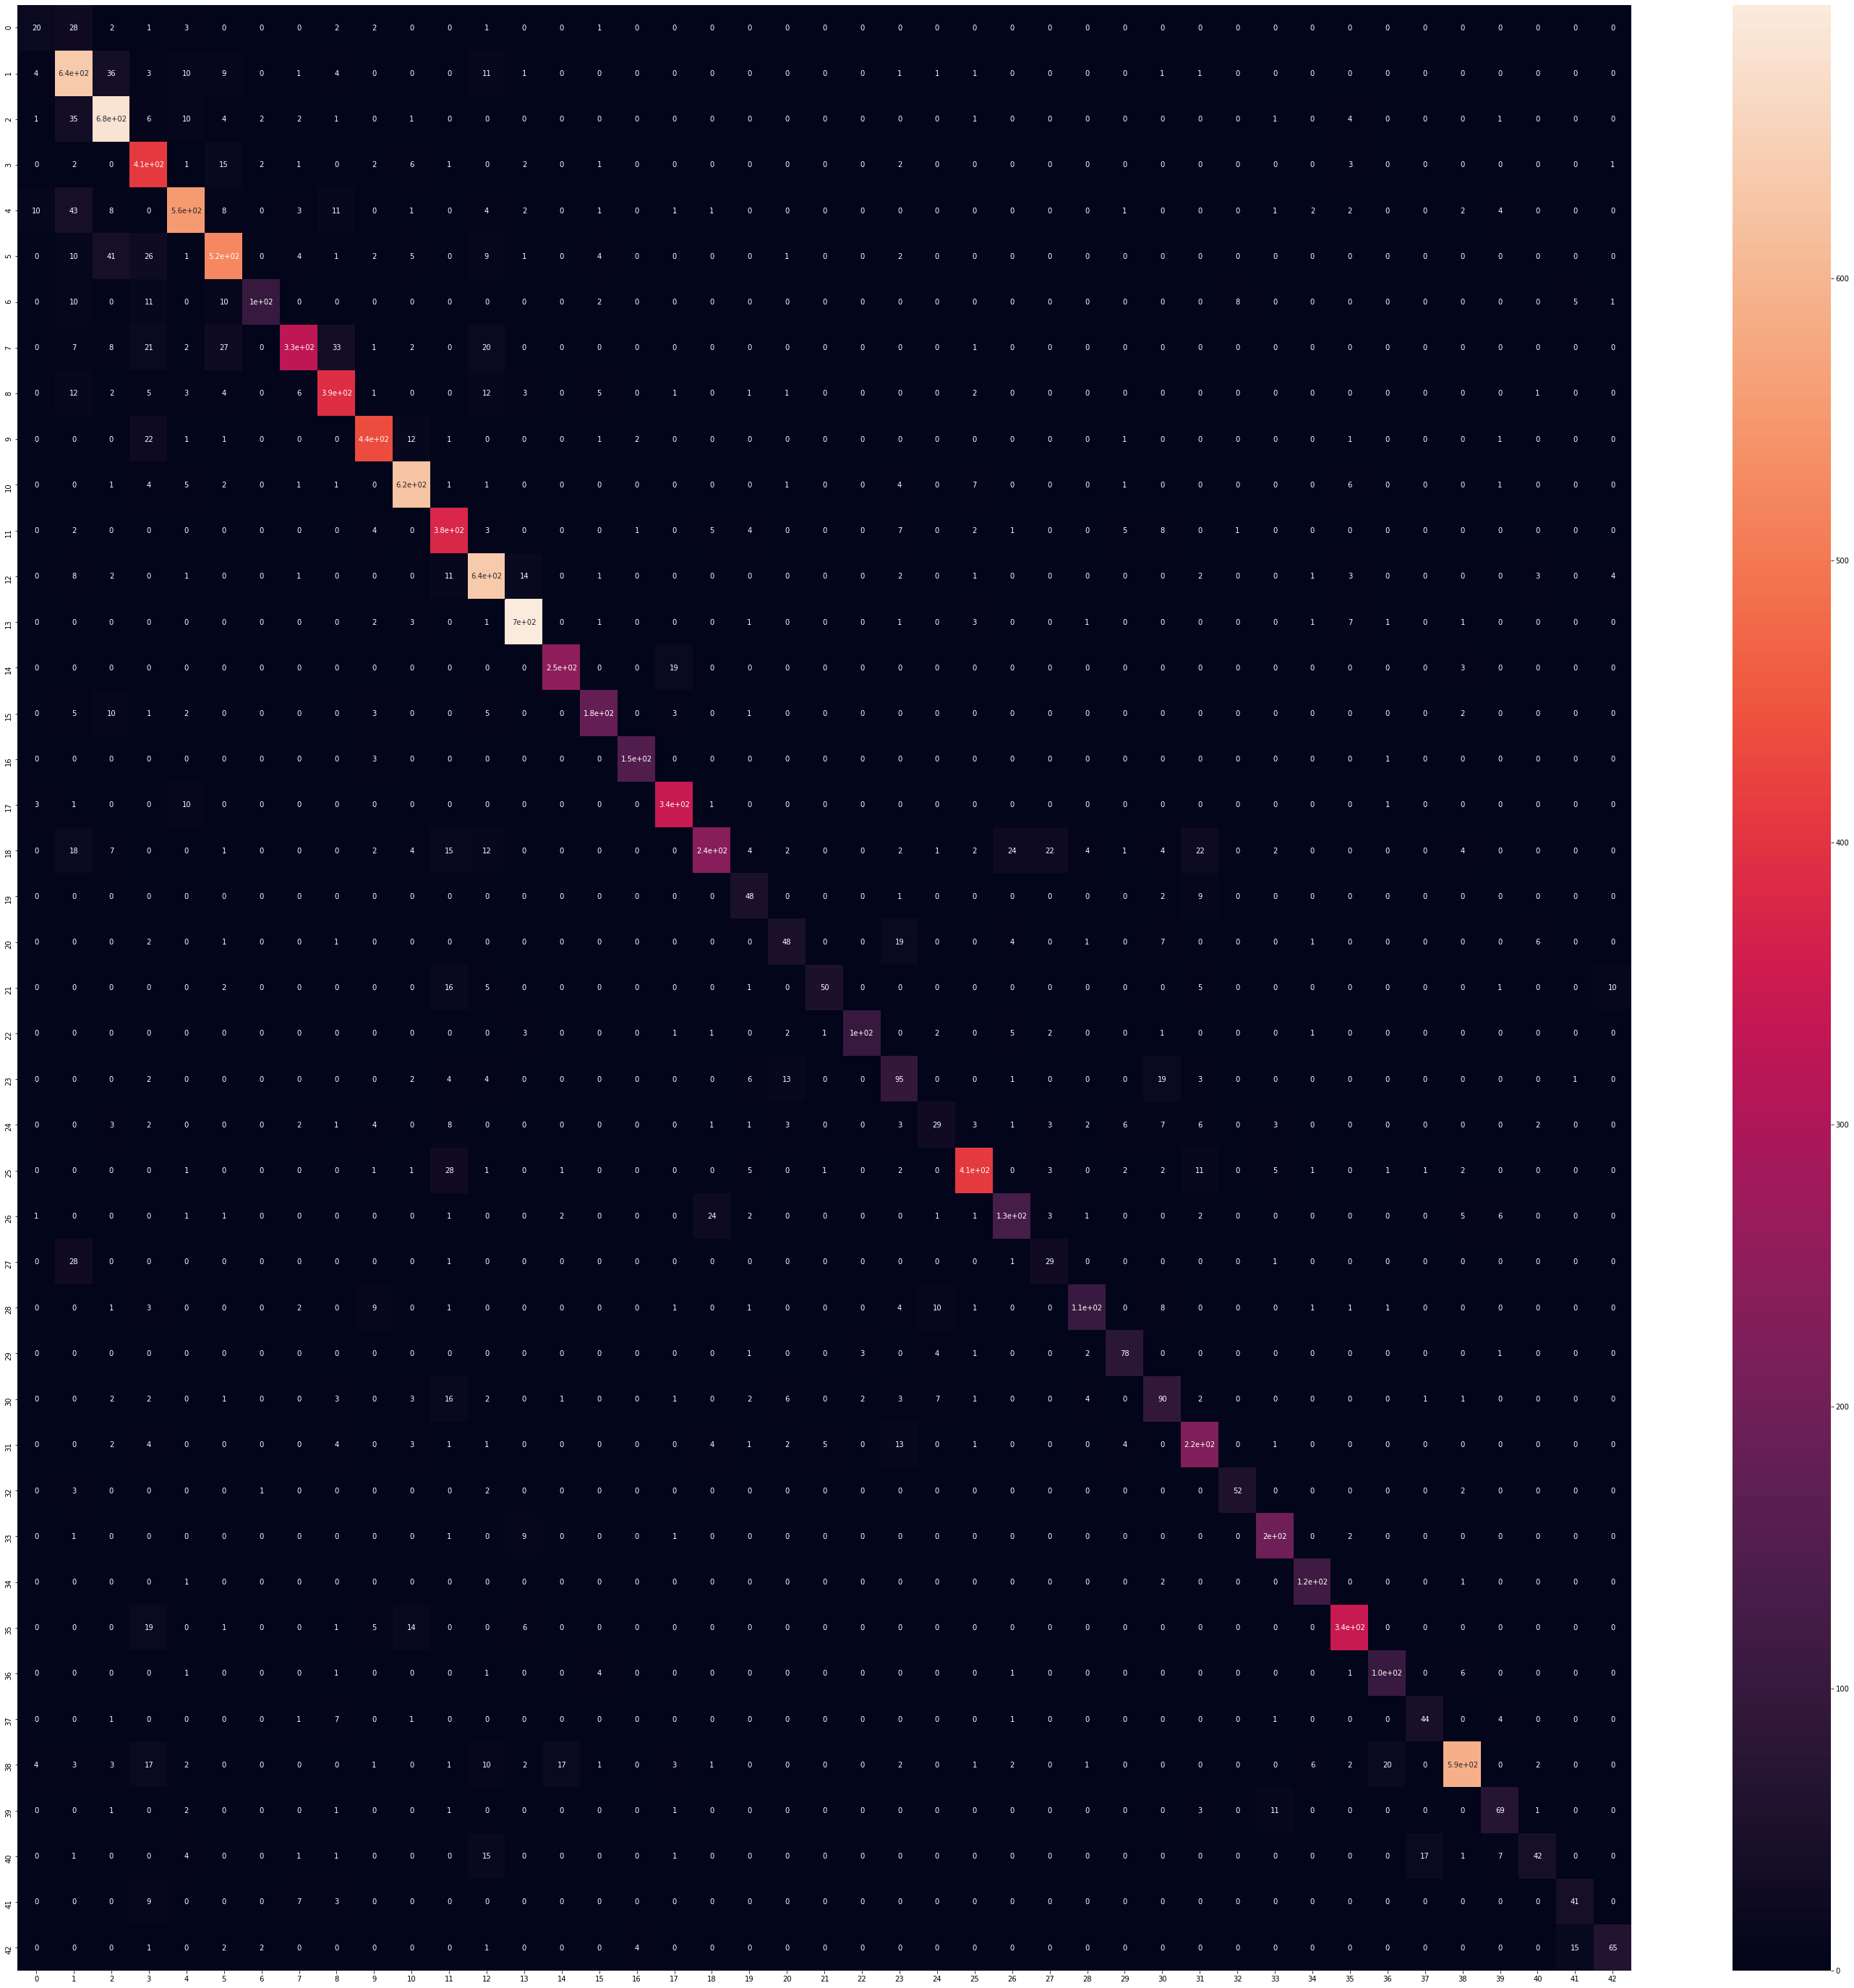

In [ ]:
print('Resultados en set de Test')
ypred = mlp.predict(Xte)
get_metrics(y_test, ypred)

*Empleando imágenes en gris la performance es prácticamente idéntica. A pesar de esto, las próximas reducciones de características las realizaremos utilizando el caso de las imágenes a color.*

#### C. Raw pixels (imagen color) con observaciones submuestreadas

*   Imagen color (3 canales)
*   Observaciones submuestreadas para balancear clases (múltiples submuestreos aleatorios)
*   Todas las features (raw pixels)

In [ ]:
models = []
results = []

print(X_train.shape, X_val.shape, X_test.shape )

for i in range(5):
  print('\nIteración %d' %(i+1))

  #Submuestreo sobre features ya procesadas
  X_train_u, y_train_u = undersampling(X_train, y_train)
  print('Submuestreo de entrenamiento:', X_train_u.shape)

  #Flatten features
  Xtr = flatten_features(X_train_u)
  Xval = flatten_features(X_val)
  Xte = flatten_features(X_test)

  mlp = MLPClassifier().fit(Xtr, y_train_u)
  models.append(mlp)
  ypred = mlp.predict(Xval)
  bal_acc = metrics.balanced_accuracy_score(y_val, ypred)
  results.append(bal_acc)
  print('Exactitud balanceada %.2f' %(bal_acc))

(34799, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3)

Iteración 1
Submuestreo de entrenamiento: (7740, 32, 32, 3)
Exactitud balanceada 0.76

Iteración 2
Submuestreo de entrenamiento: (7740, 32, 32, 3)
Exactitud balanceada 0.79

Iteración 3
Submuestreo de entrenamiento: (7740, 32, 32, 3)
Exactitud balanceada 0.79

Iteración 4
Submuestreo de entrenamiento: (7740, 32, 32, 3)
Exactitud balanceada 0.80

Iteración 5
Submuestreo de entrenamiento: (7740, 32, 32, 3)
Exactitud balanceada 0.77


Resultados en set de Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.76      0.80      0.78       720
           2       0.90      0.76      0.82       750
           3       0.71      0.87      0.78       450
           4       0.76      0.78      0.77       660
           5       0.74      0.80      0.77       630
           6       0.77      0.63      0.69       150
           7       0.75      0.70      0.72       450
           8       0.79      0.79      0.79       450
           9       0.90      0.90      0.90       480
          10       0.88      0.91      0.89       660
          11       0.90      0.79      0.84       420
          12       0.97      0.85      0.91       690
          13       0.93      0.93      0.93       720
          14       0.96      0.96      0.96       270
          15       0.81      0.88      0.84       210
          16       0.94      0.97      0.96       150
 

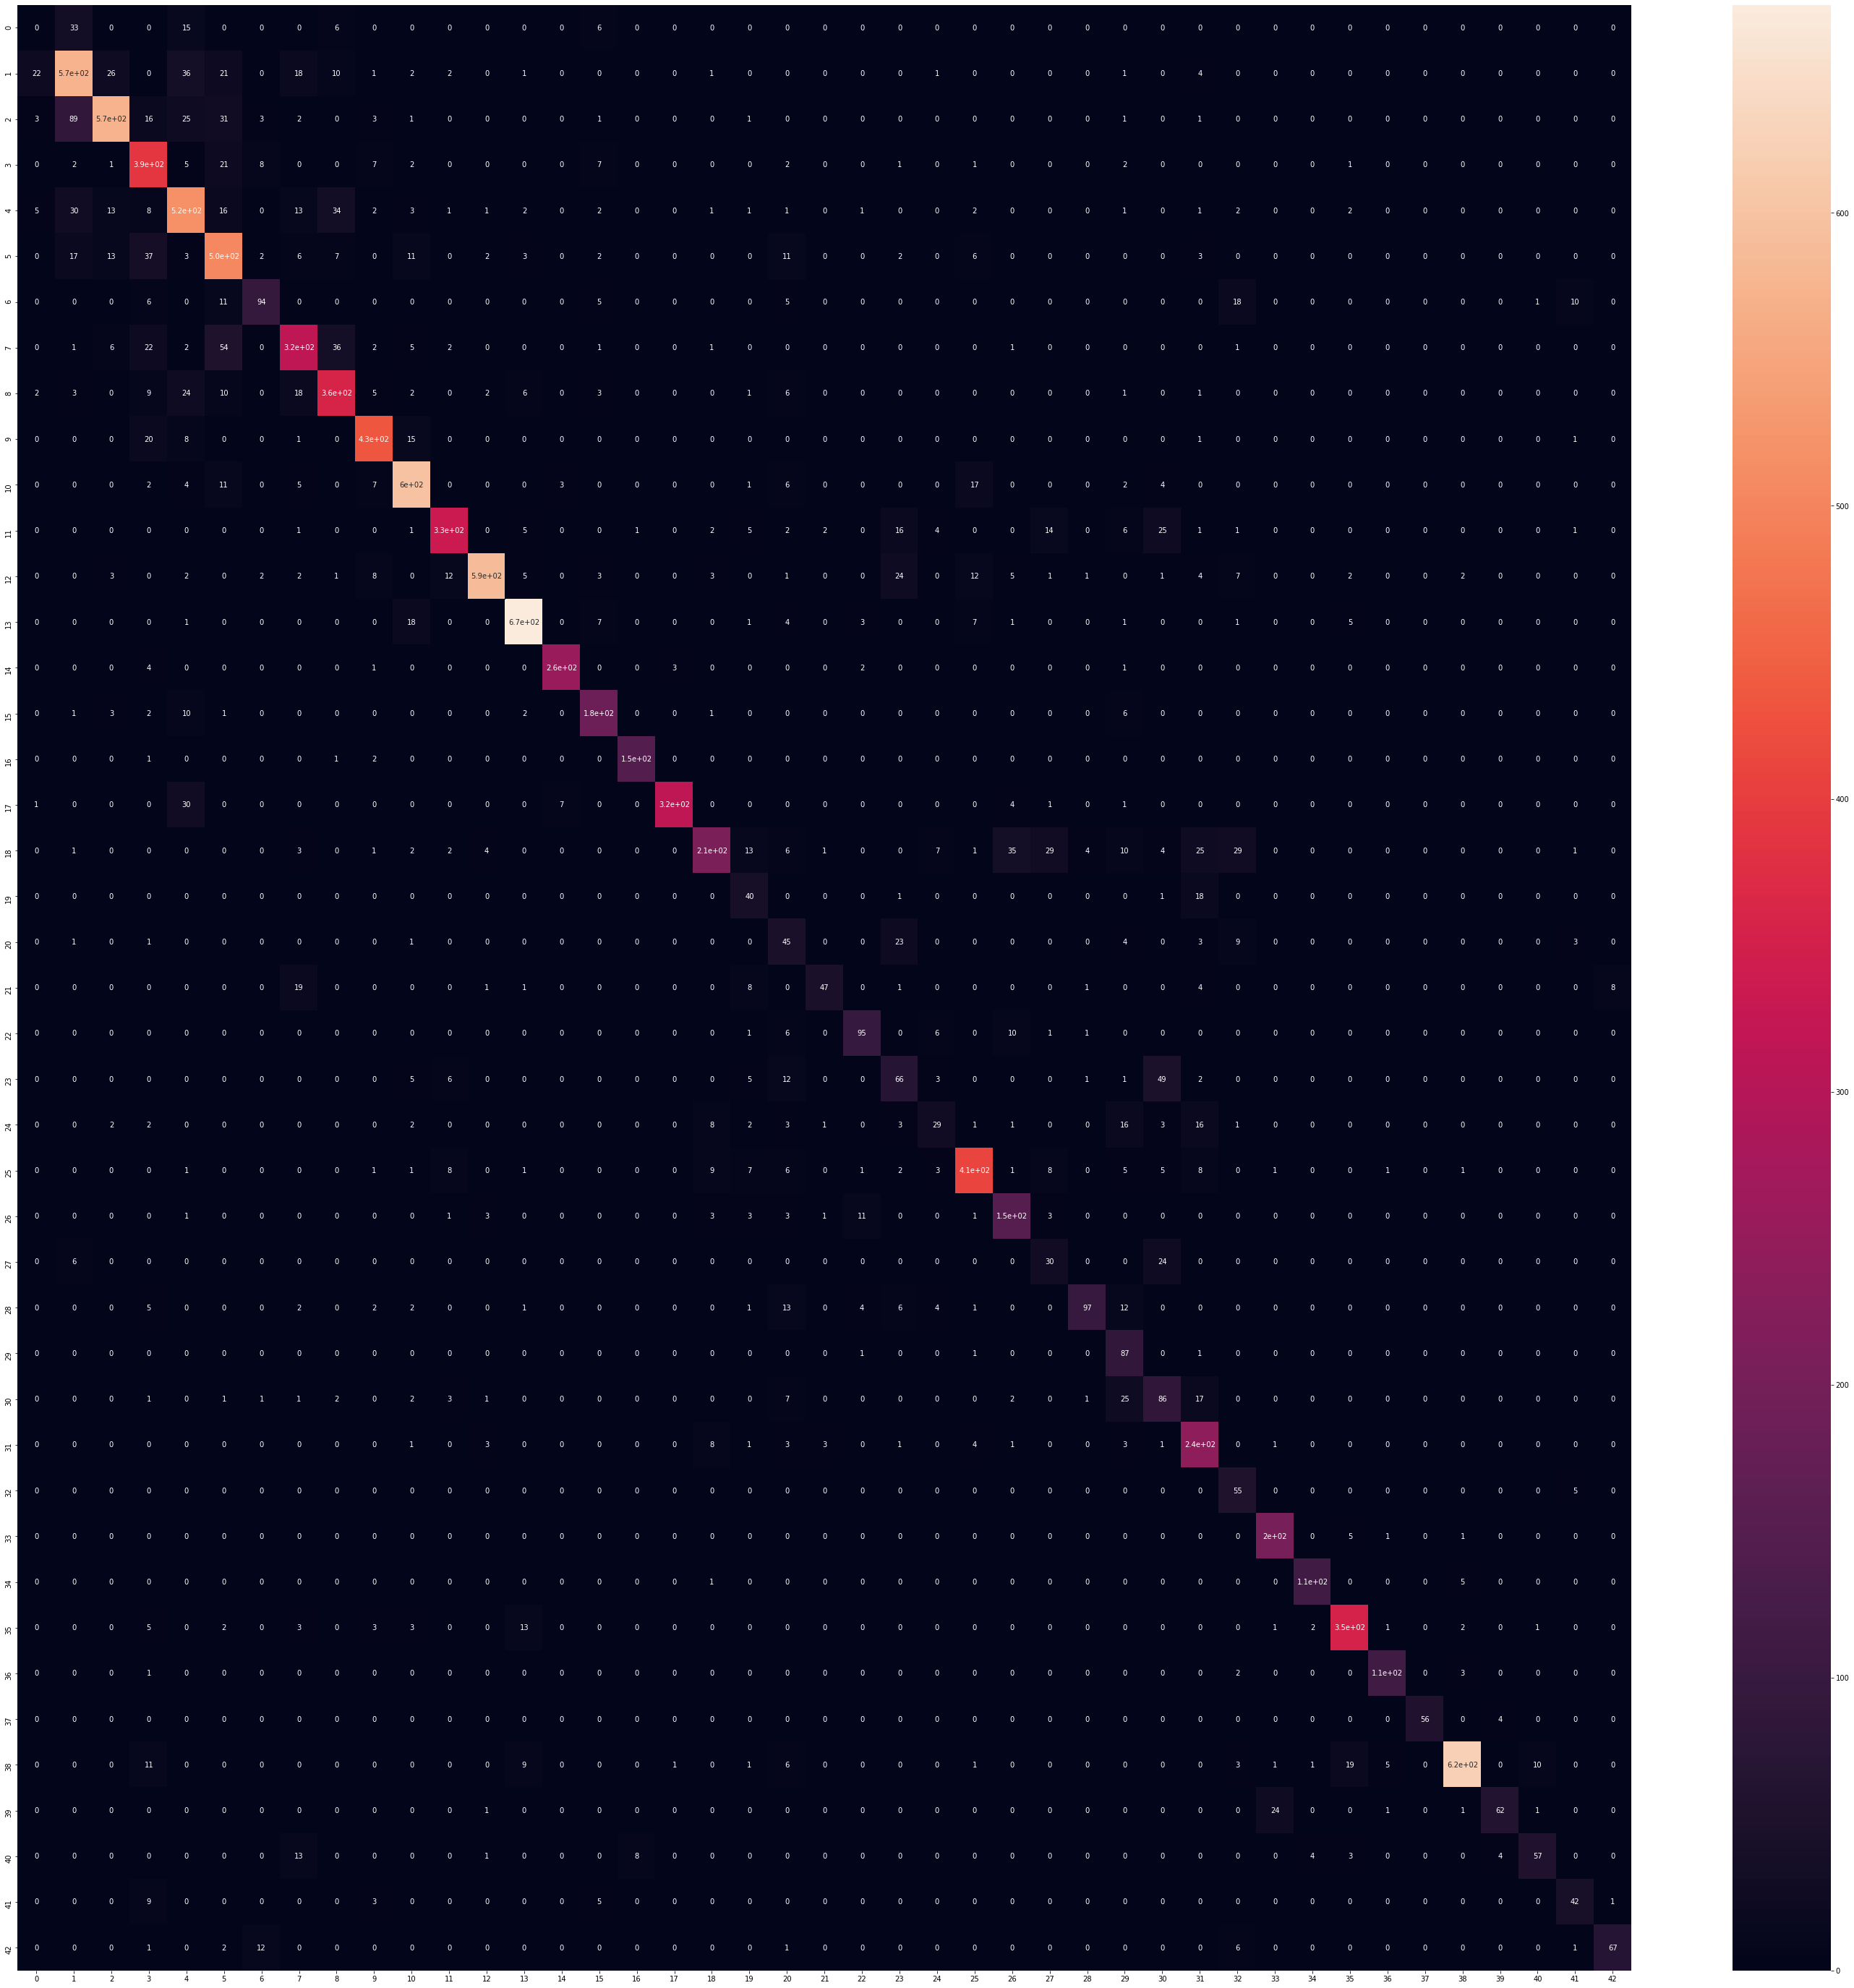

In [ ]:
#Uso de mejor modelo en validación
print('Resultados en set de Test')
nro_iteracion = 4
ypred = models[nro_iteracion-1].predict(Xte)
get_metrics(y_test, ypred)

*Realizamos múltiples particiones del set de entrenamiento de modo que todas las clases quedaran balanceadas en cada una de ellas. Con cada partición realizamos un nuevo entrenamiento y reportamos los resultados en el set de validación. Conservamos el modelo con mejor resultado en este conjunto y lo evaluamos en el set independiente de testeo. Si bien la exactitud es muy buena de acuerdo al reporte de clasificación, podemos notar que para la clase 0, no existe ningún acierto (algo que no había ocurrido hasta entonces). De esta manera, si bien existe una reducción importante en el tiempo de entrenamiento de los modelos, ello no justifica perder la capacidad de detectar una de las señales.*

#### D. Raw pixels (imagen color) con selección de features
*   Imagen color (3 canales)
*   Todas las observaciones
*   Selección de features (raw pixels)

In [ ]:
#Flatten features
Xtr = flatten_features(X_train)
Xval = flatten_features(X_val)
Xte = flatten_features(X_test)

#Selección de features
Xtr, Xval, Xte = select_features(Xtr,y_train, Xval, Xte)

Xtr.shape, Xval.shape, Xte.shape

((34799, 792), (4410, 792), (12630, 792))

In [ ]:
mlp = MLPClassifier().fit(Xtr, y_train)

Resultados en set de Validación
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.06      0.10      0.07       240
           2       0.11      0.33      0.16       240
           3       0.05      0.04      0.04       150
           4       0.08      0.06      0.07       210
           5       0.03      0.03      0.03       210
           6       0.00      0.00      0.00        60
           7       0.05      0.01      0.02       150
           8       0.03      0.04      0.03       150
           9       0.00      0.00      0.00       150
          10       0.04      0.08      0.05       210
          11       0.04      0.02      0.03       150
          12       0.04      0.04      0.04       210
          13       0.06      0.11      0.07       240
          14       0.00      0.00      0.00        90
          15       0.00      0.00      0.00        90
          16       0.00      0.00      0.00      

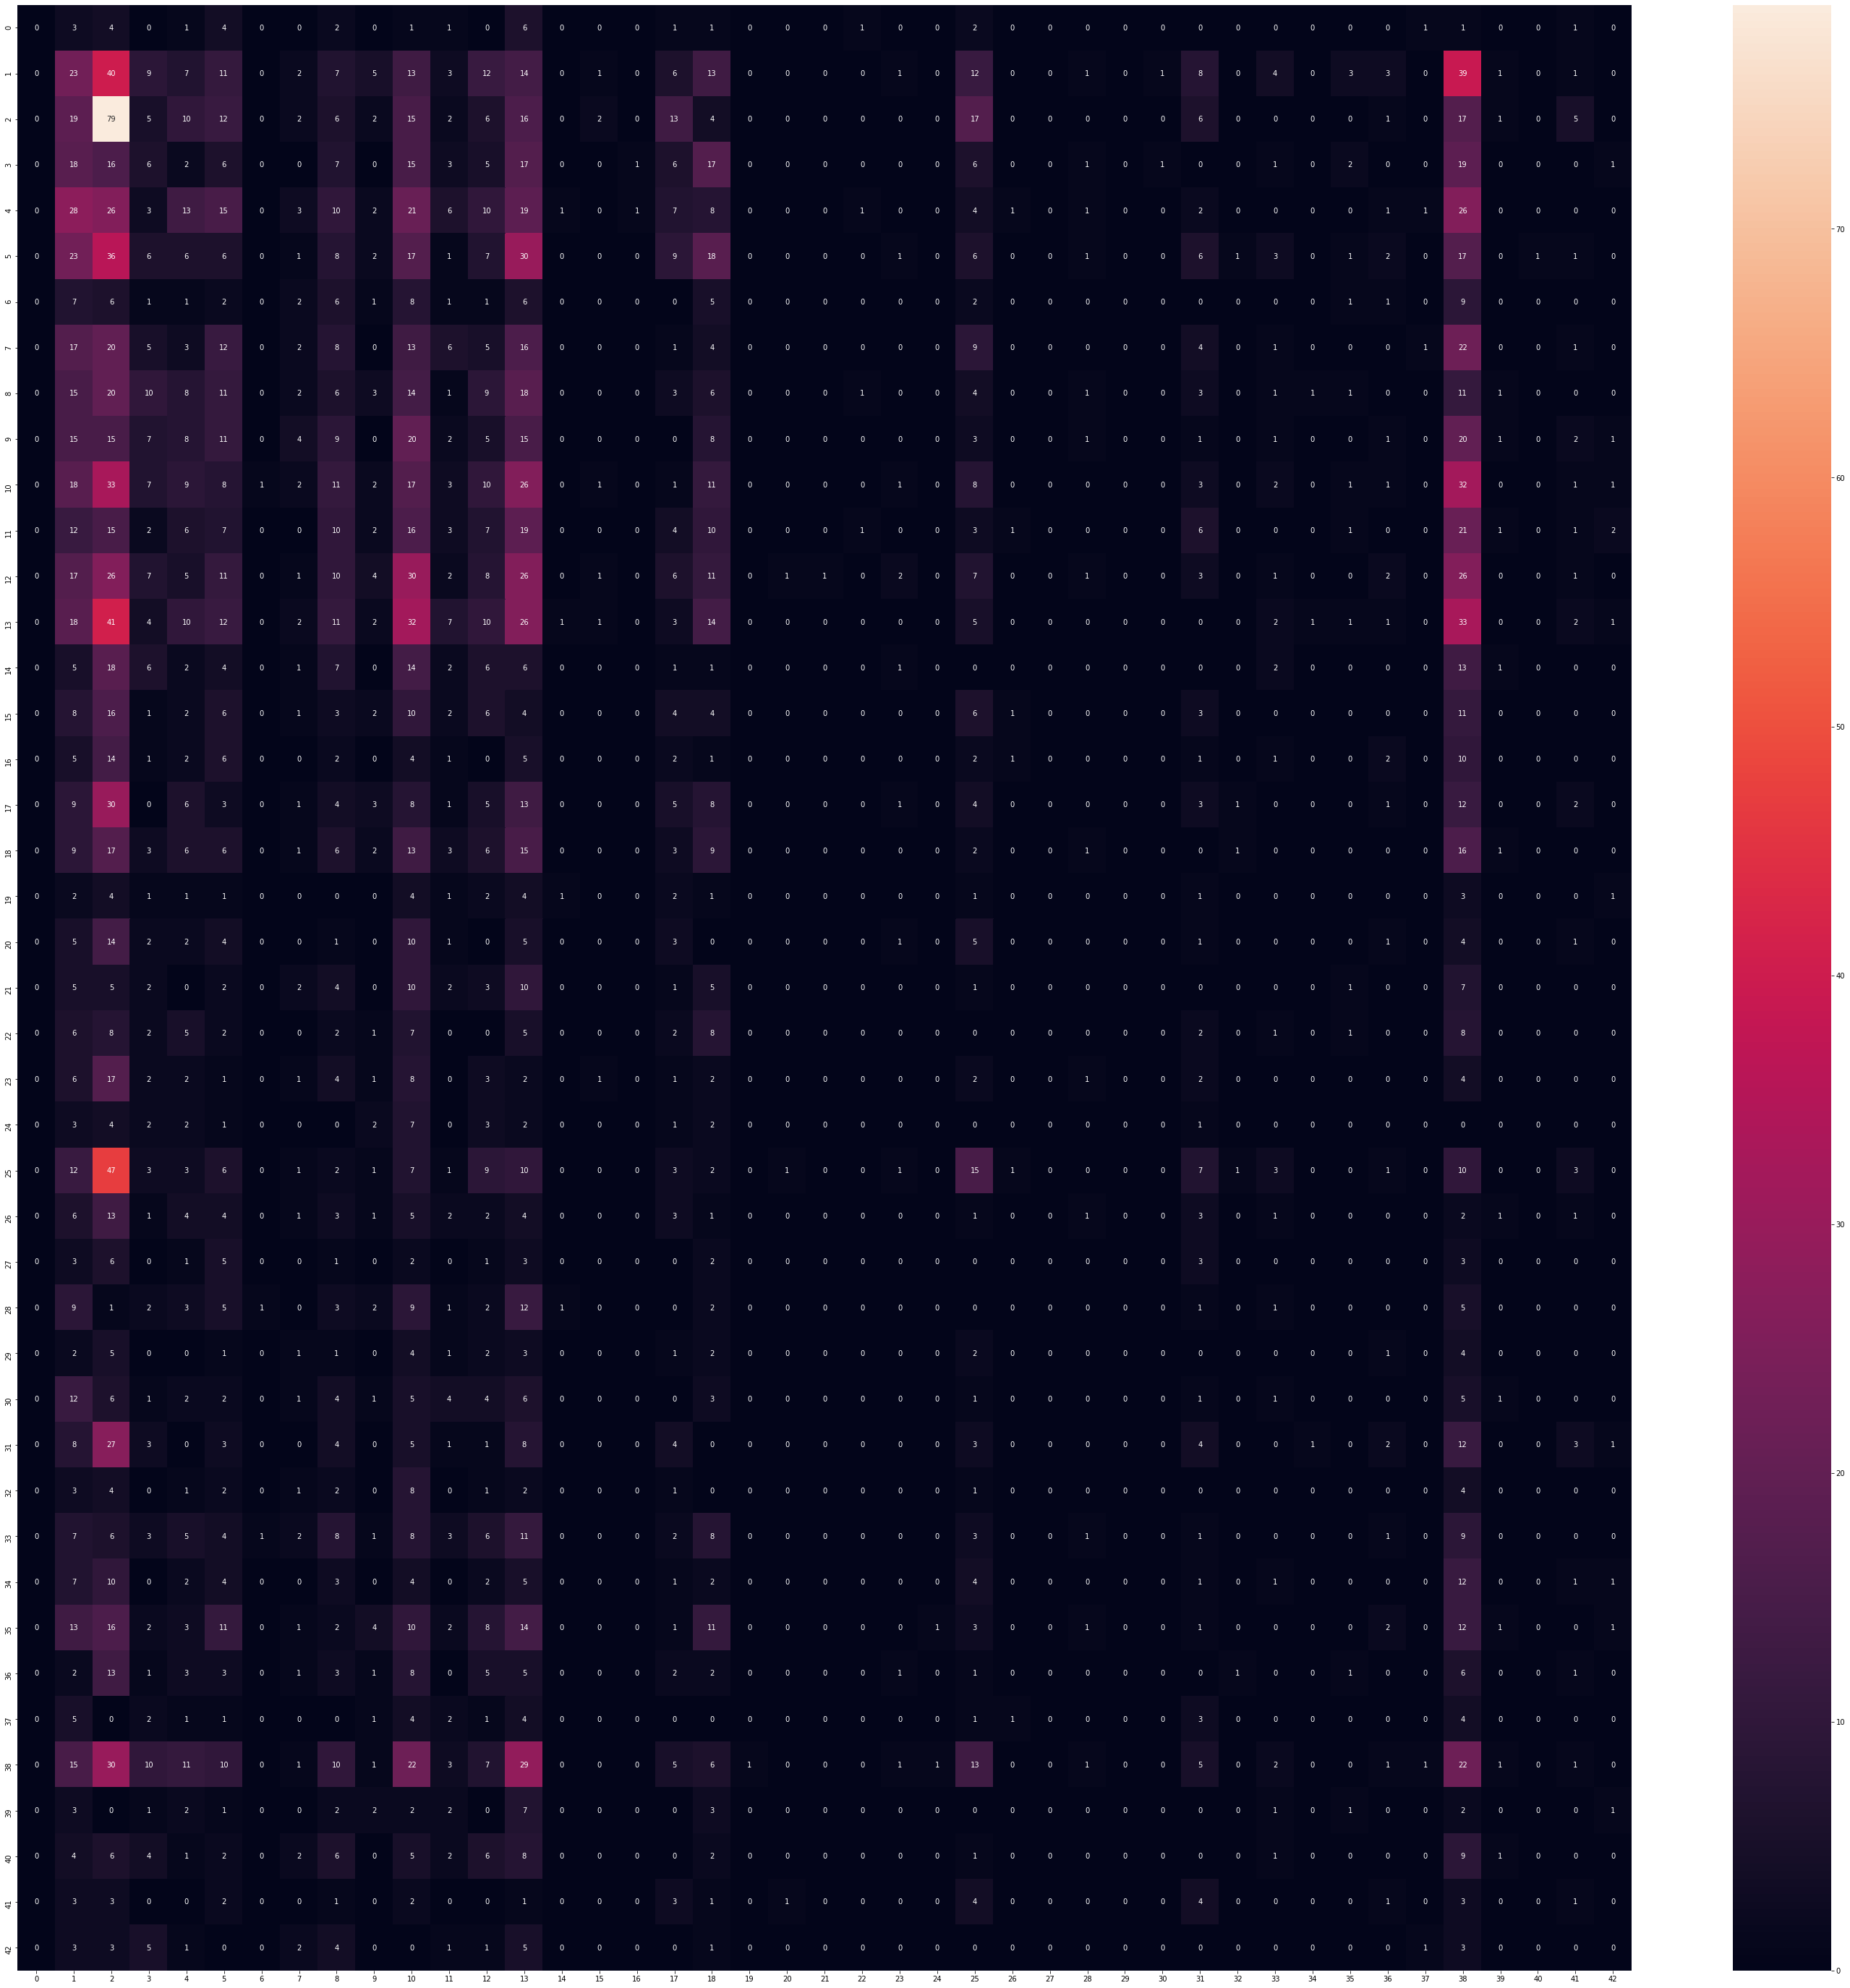

In [ ]:
print('Resultados en set de Validación')
ypred = mlp.predict(Xval)
get_metrics(y_val, ypred)

Resultados en set de Test
              precision    recall  f1-score   support

           0       0.03      0.02      0.02        60
           1       0.06      0.09      0.07       720
           2       0.06      0.21      0.09       750
           3       0.04      0.01      0.02       450
           4       0.07      0.01      0.02       660
           5       0.06      0.03      0.04       630
           6       0.00      0.00      0.00       150
           7       0.03      0.00      0.01       450
           8       0.03      0.01      0.01       450
           9       0.00      0.00      0.00       480
          10       0.04      0.01      0.02       660
          11       0.00      0.00      0.00       420
          12       0.05      0.03      0.04       690
          13       0.07      0.01      0.02       720
          14       0.03      0.00      0.01       270
          15       0.01      0.00      0.01       210
          16       0.00      0.00      0.00       150
 

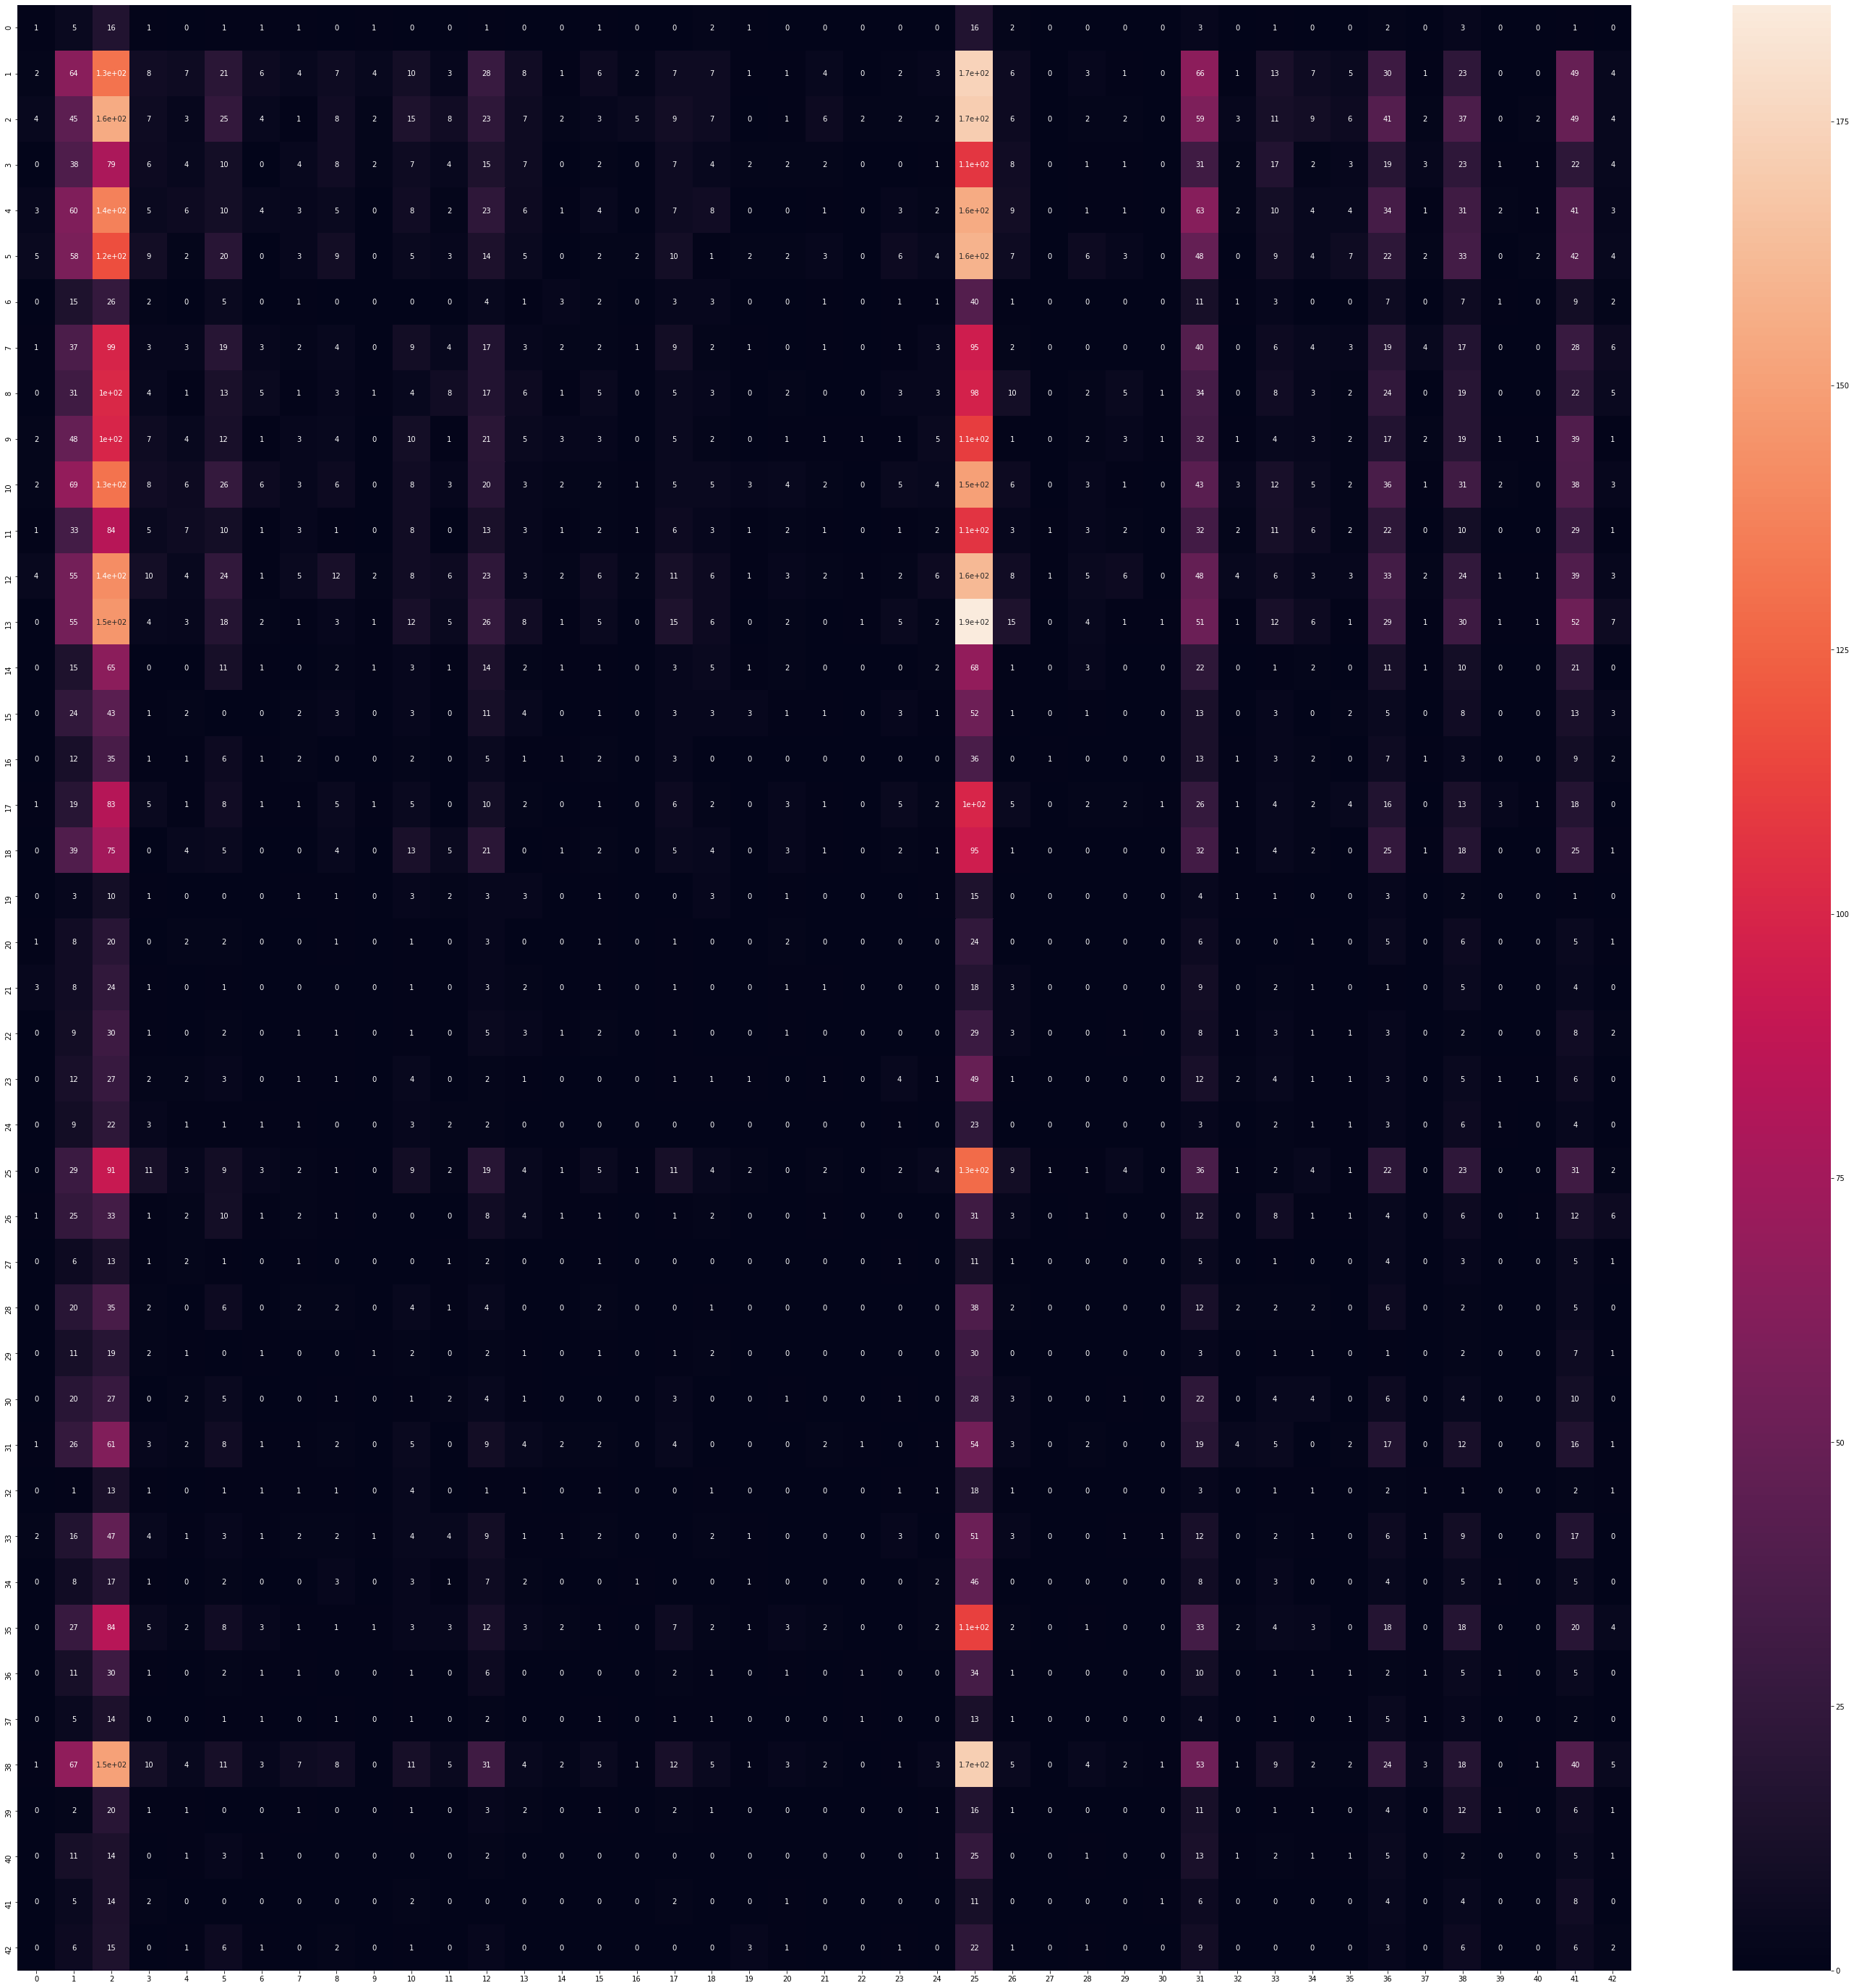

In [ ]:
print('Resultados en set de Test')
ypred = mlp.predict(Xte)
get_metrics(y_test, ypred)

*La selección de features de la matriz de píxeles originales no es funcional debido a que el rendimiento del modelo generado a partir de las características seleccionadas es inaceptable.*

#### E. Features obtenidas mediante autoencoder (imagen color)
*   Imagen color (3 canales)
*   Todas las observaciones
*   Extracción de features (autoencoders)

Epoch 1/100
68/68 [==============================] - 8s 97ms/step - loss: 49.3474 - val_loss: 59.2456
Epoch 2/100
68/68 [==============================] - 5s 74ms/step - loss: 10.9560 - val_loss: 25.1564
Epoch 3/100
68/68 [==============================] - 5s 74ms/step - loss: 9.2013 - val_loss: 24.2588
Epoch 4/100
68/68 [==============================] - 5s 74ms/step - loss: 8.6689 - val_loss: 20.4291
Epoch 5/100
68/68 [==============================] - 5s 73ms/step - loss: 8.2434 - val_loss: 16.2110
Epoch 6/100
68/68 [==============================] - 5s 73ms/step - loss: 7.6547 - val_loss: 12.2358
Epoch 7/100
68/68 [==============================] - 5s 73ms/step - loss: 7.1712 - val_loss: 9.2593
Epoch 8/100
68/68 [==============================] - 5s 72ms/step - loss: 6.8444 - val_loss: 8.2143
Epoch 9/100
68/68 [==============================] - 5s 72ms/step - loss: 6.8267 - val_loss: 7.5274
Epoch 10/100
68/68 [==============================] - 5s 72ms/step - loss: 6.5409 - val_loss

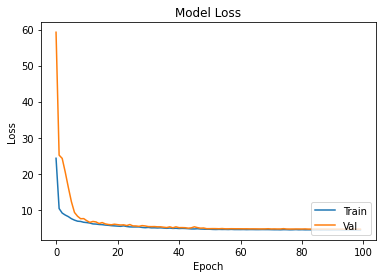

In [ ]:
latent_size = 10
input_size = (32,32,3)

encoder_ae, model_ae = adjust_ae(X_train, X_val, input_size, latent_size)

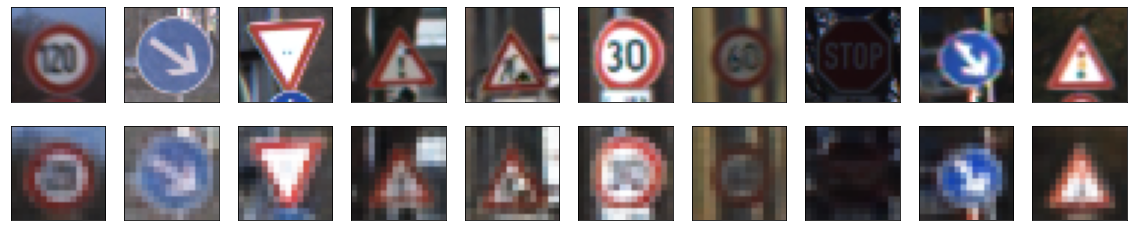

In [ ]:
plot_reconstructions(X_test, model_ae.predict(X_test))

In [ ]:
#Features del espacio latente
Xtr_ae = encoder_ae.predict(X_train)
Xval_ae = encoder_ae.predict(X_val)
Xte_ae = encoder_ae.predict(X_test) 

#Flatten features
Xtr = flatten_features(Xtr_ae)
Xval = flatten_features(Xval_ae)
Xte = flatten_features(Xte_ae)

Xtr.shape, Xval.shape, Xte.shape

((34799, 640), (4410, 640), (12630, 640))

In [ ]:
mlp = MLPClassifier().fit(Xtr, y_train)

Resultados en set de Validación
              precision    recall  f1-score   support

           0       1.00      0.13      0.24        30
           1       0.69      0.86      0.76       240
           2       0.70      0.75      0.73       240
           3       0.72      0.83      0.77       150
           4       0.64      0.67      0.65       210
           5       0.65      0.68      0.67       210
           6       0.75      0.65      0.70        60
           7       0.54      0.65      0.59       150
           8       0.74      0.52      0.61       150
           9       0.90      0.95      0.93       150
          10       0.98      1.00      0.99       210
          11       0.80      0.93      0.86       150
          12       0.99      1.00      0.99       210
          13       0.99      0.98      0.98       240
          14       0.97      0.97      0.97        90
          15       0.91      0.87      0.89        90
          16       0.96      0.37      0.53      

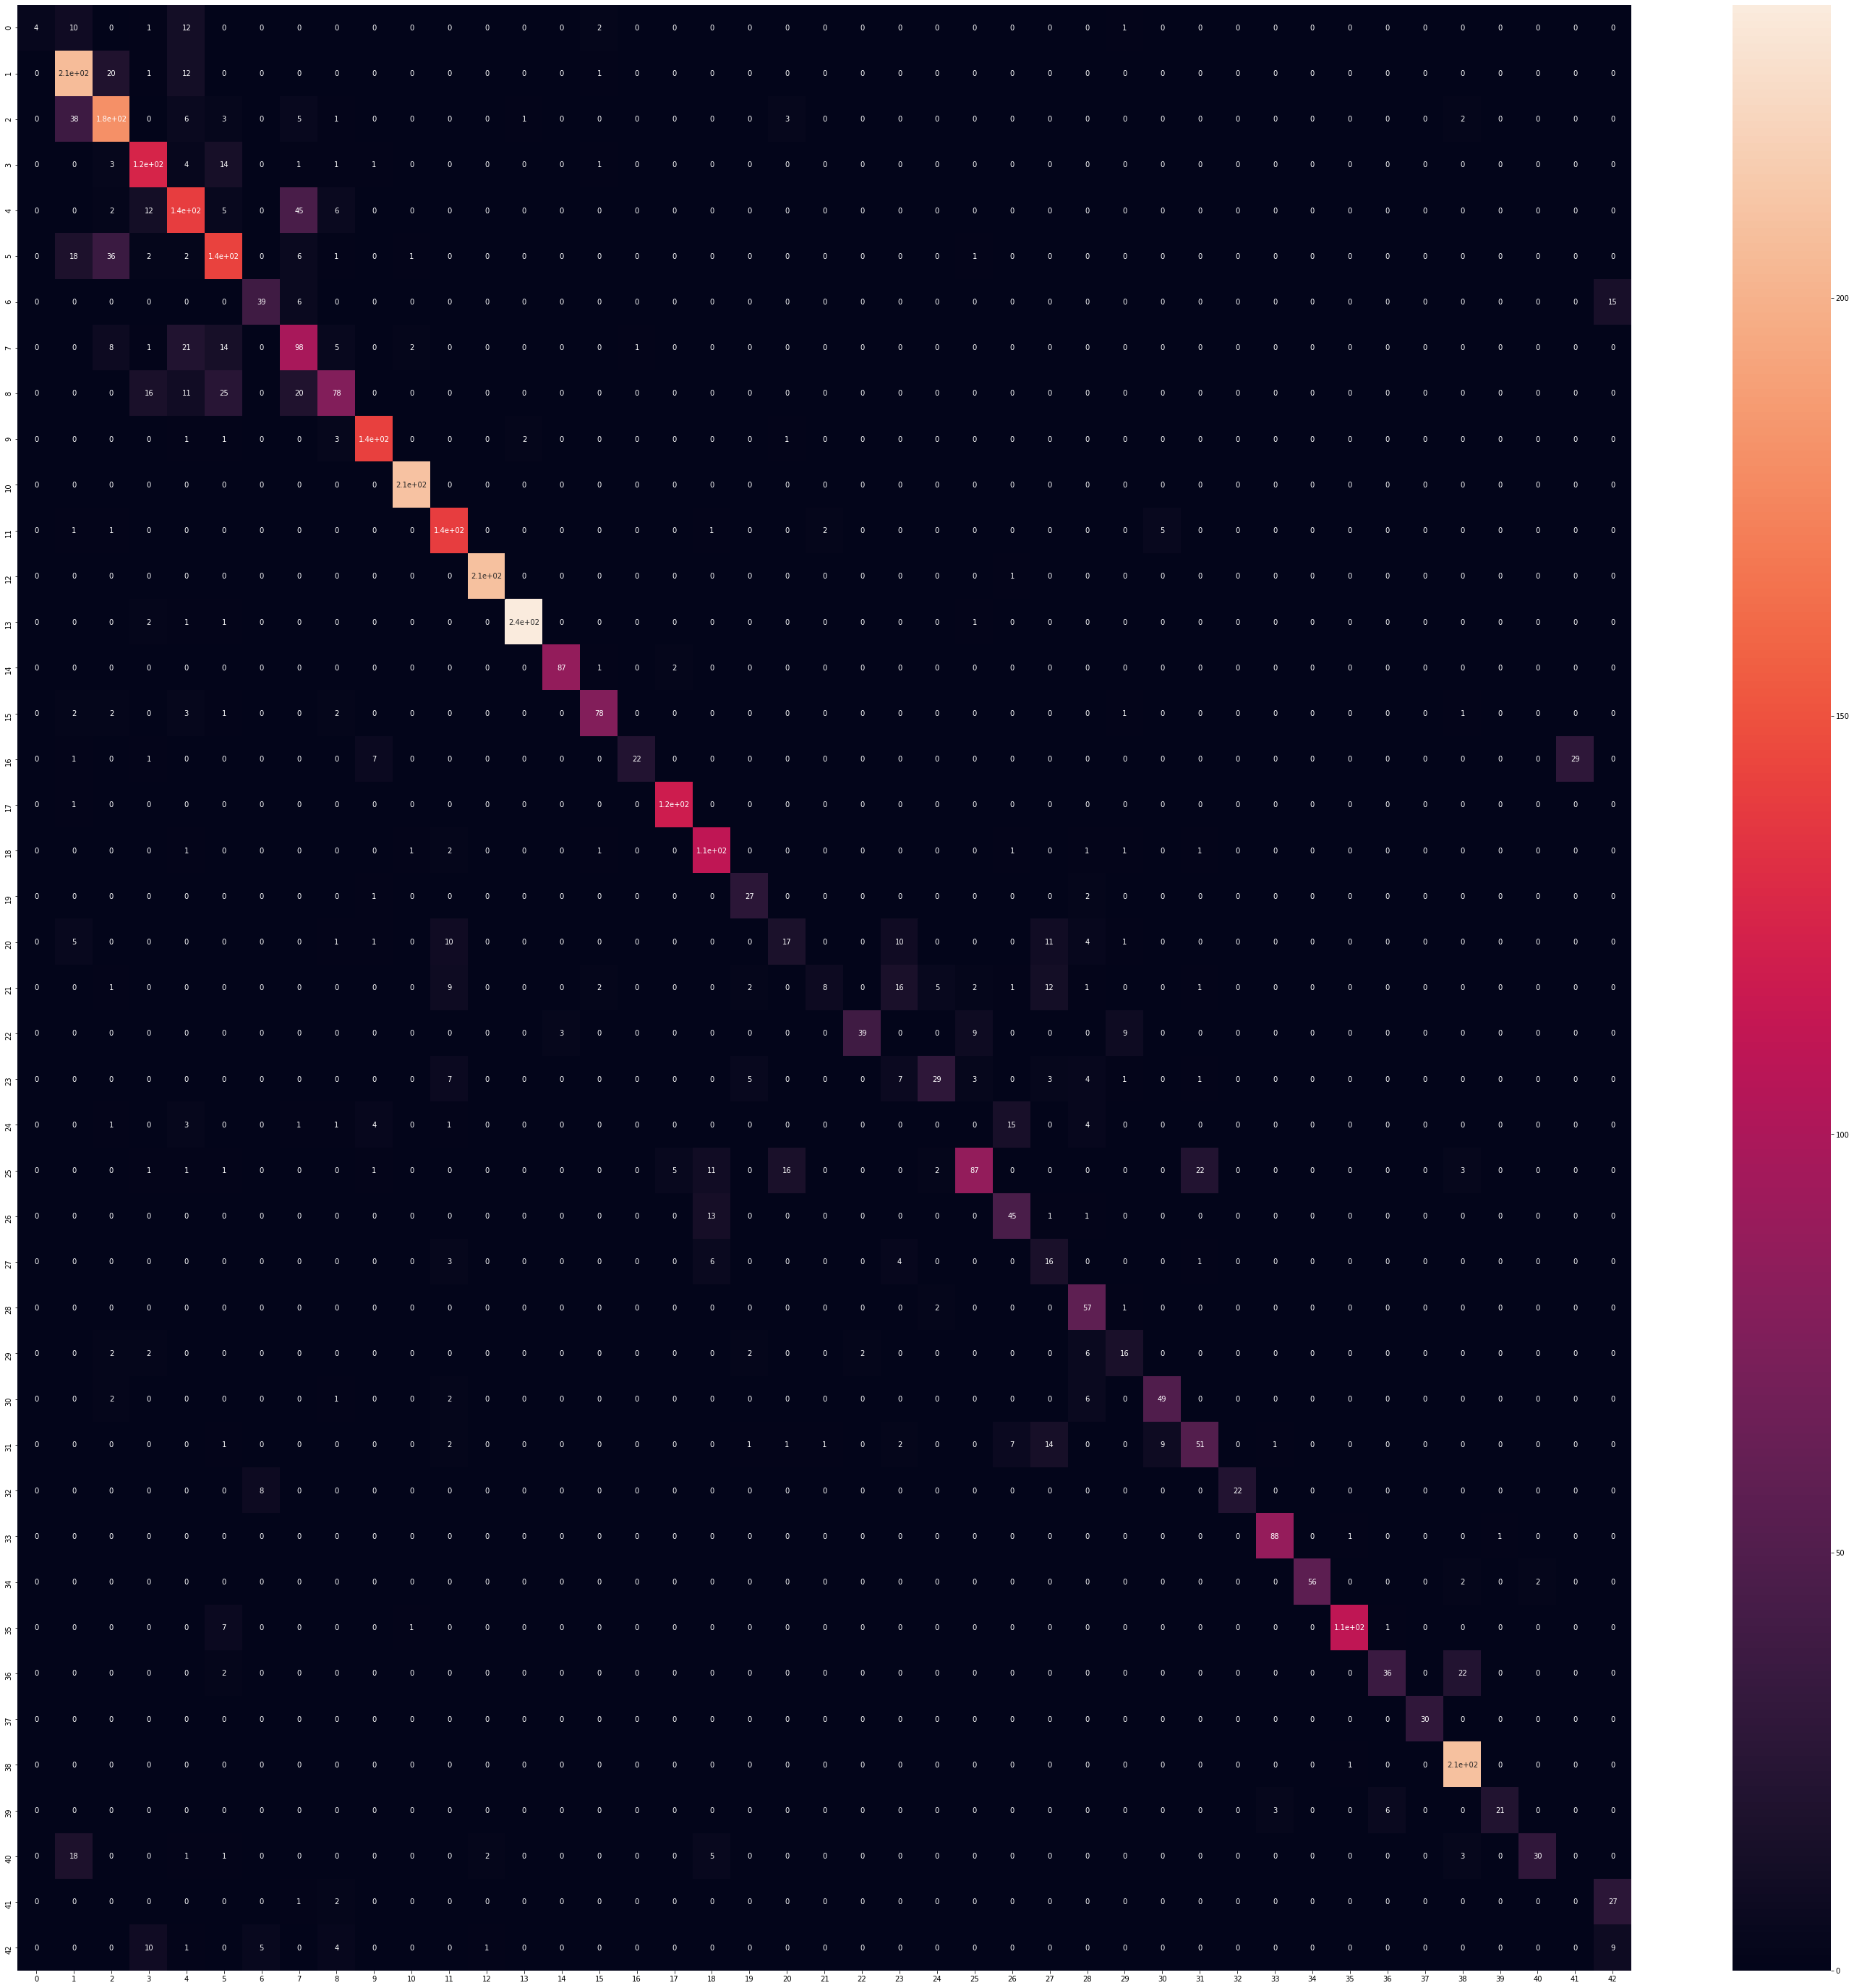

In [ ]:
print('Resultados en set de Validación')
ypred = mlp.predict(Xval)
get_metrics(y_val, ypred)

Resultados en set de Test
              precision    recall  f1-score   support

           0       0.70      0.23      0.35        60
           1       0.74      0.83      0.78       720
           2       0.72      0.82      0.77       750
           3       0.70      0.67      0.69       450
           4       0.69      0.78      0.73       660
           5       0.64      0.71      0.68       630
           6       0.67      0.55      0.60       150
           7       0.74      0.61      0.67       450
           8       0.71      0.79      0.75       450
           9       0.88      0.88      0.88       480
          10       0.97      0.92      0.95       660
          11       0.82      0.89      0.85       420
          12       0.99      0.93      0.96       690
          13       0.97      0.98      0.98       720
          14       1.00      0.99      1.00       270
          15       0.88      0.91      0.89       210
          16       0.79      0.95      0.86       150
 

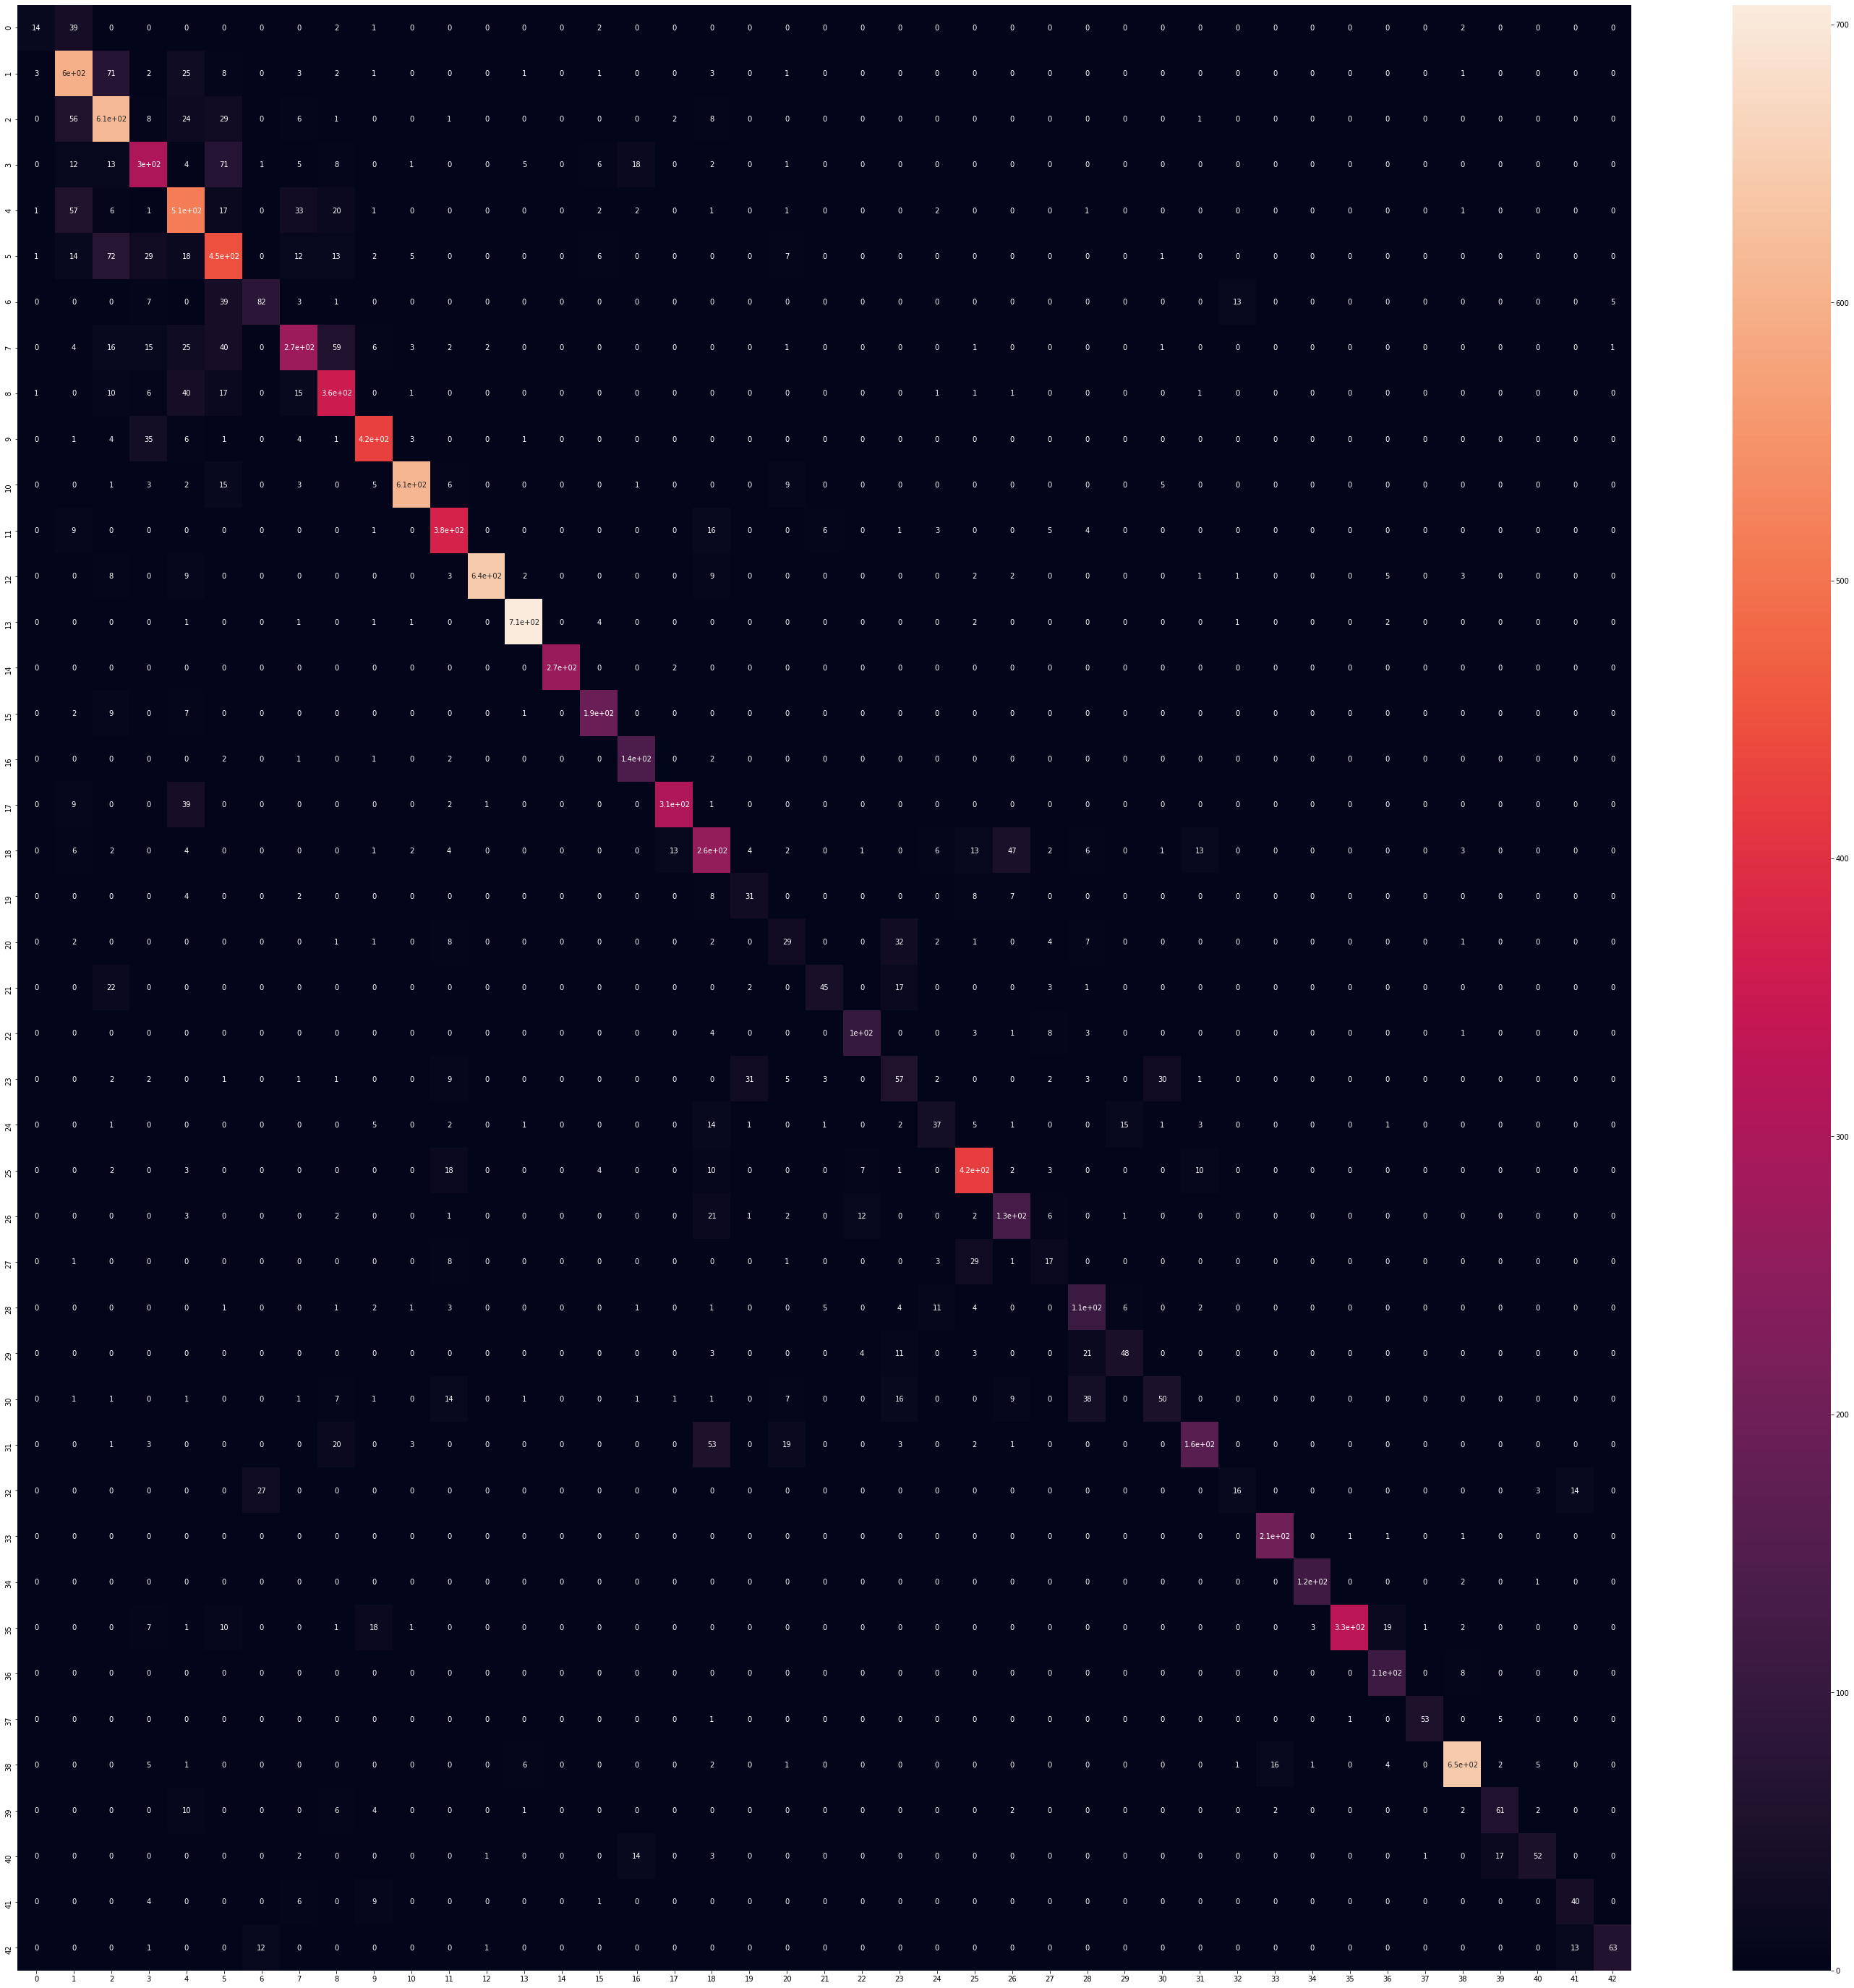

In [ ]:
print('Resultados en set de Test')
ypred = mlp.predict(Xte)
get_metrics(y_test, ypred)

*Entrenamos un autoencoder para reconstruir las imágenes originales, con el propósito luego de obtener las características generadas por el bloque codificador y de esta manera reducir la cantidad de atributos a la entrada del clasificador. Si bien la performance en entrenamiento es acpetable y todas las clases son detectadas en mayor o menor medida, hay dos clases que se pierden en el set de validación.*

#### F. Features seleccionadas de las obtenidas mediante autoencoder (imagen color)
*   Imagen color (3 canales)
*   Todas las observaciones
*   Extracción de features (autoencoders)
*   Selección de features (autoencoders)

In [ ]:
#Features del espacio latente
Xtr_ae = encoder_ae.predict(X_train)
Xval_ae = encoder_ae.predict(X_val)
Xte_ae = encoder_ae.predict(X_test) 

#Flatten features
Xtr = flatten_features(Xtr_ae)
Xval = flatten_features(Xval_ae)
Xte = flatten_features(Xte_ae)

#Selección de features
#Selección de features
Xtr, Xval, Xte = select_features(Xtr,y_train, Xval, Xte)

Xtr.shape, Xval.shape, Xte.shape

((34799, 178), (4410, 178), (12630, 178))

In [ ]:
mlp = MLPClassifier().fit(Xtr, y_train)

Resultados en set de Validación
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.07      0.09      0.08       240
           2       0.09      0.17      0.12       240
           3       0.02      0.03      0.02       150
           4       0.05      0.07      0.06       210
           5       0.05      0.04      0.04       210
           6       0.00      0.00      0.00        60
           7       0.05      0.05      0.05       150
           8       0.06      0.05      0.05       150
           9       0.05      0.03      0.04       150
          10       0.09      0.14      0.11       210
          11       0.05      0.04      0.04       150
          12       0.06      0.10      0.07       210
          13       0.06      0.10      0.08       240
          14       0.04      0.03      0.04        90
          15       0.02      0.01      0.01        90
          16       0.00      0.00      0.00      

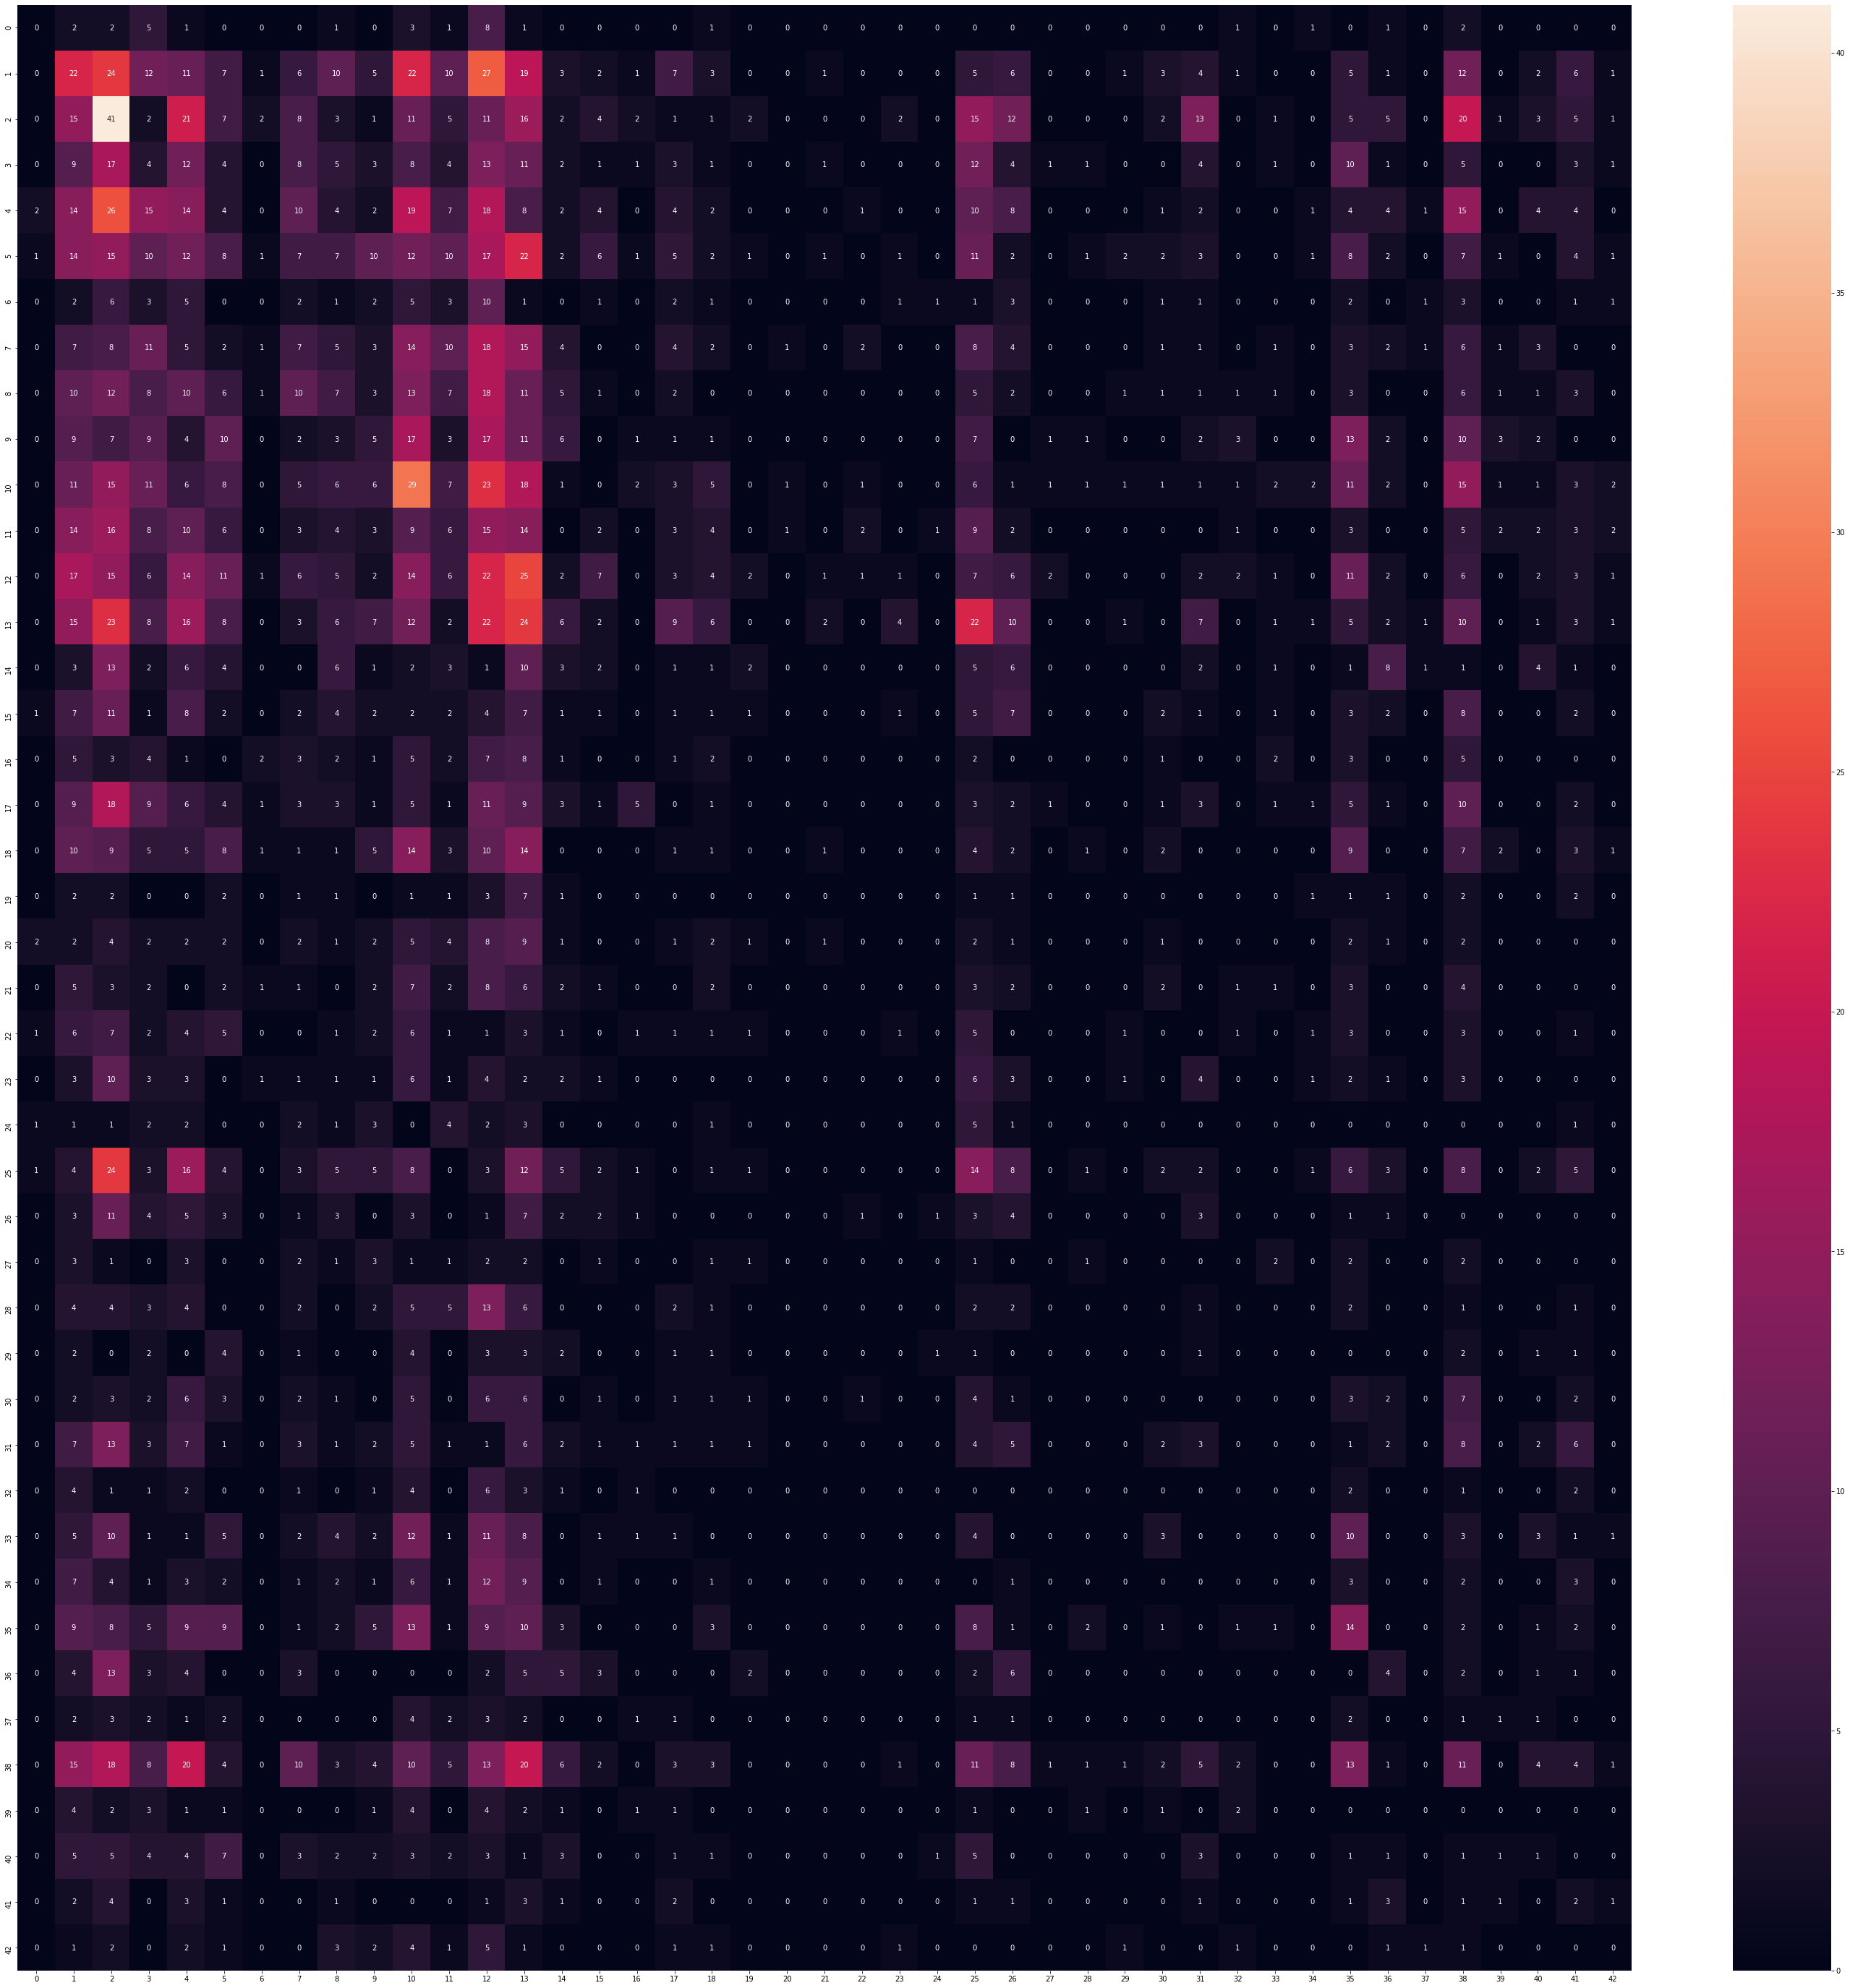

In [ ]:
print('Resultados en set de Validación')
ypred = mlp.predict(Xval)
get_metrics(y_val, ypred)

Resultados en set de Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.06      0.01      0.01       720
           2       0.07      0.17      0.10       750
           3       0.02      0.00      0.00       450
           4       0.07      0.03      0.04       660
           5       0.17      0.00      0.00       630
           6       0.04      0.01      0.01       150
           7       0.03      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.50      0.00      0.00       660
          11       0.06      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.06      0.02      0.03       720
          14       0.02      0.13      0.04       270
          15       0.02      0.02      0.02       210
          16       0.00      0.00      0.00       150
 

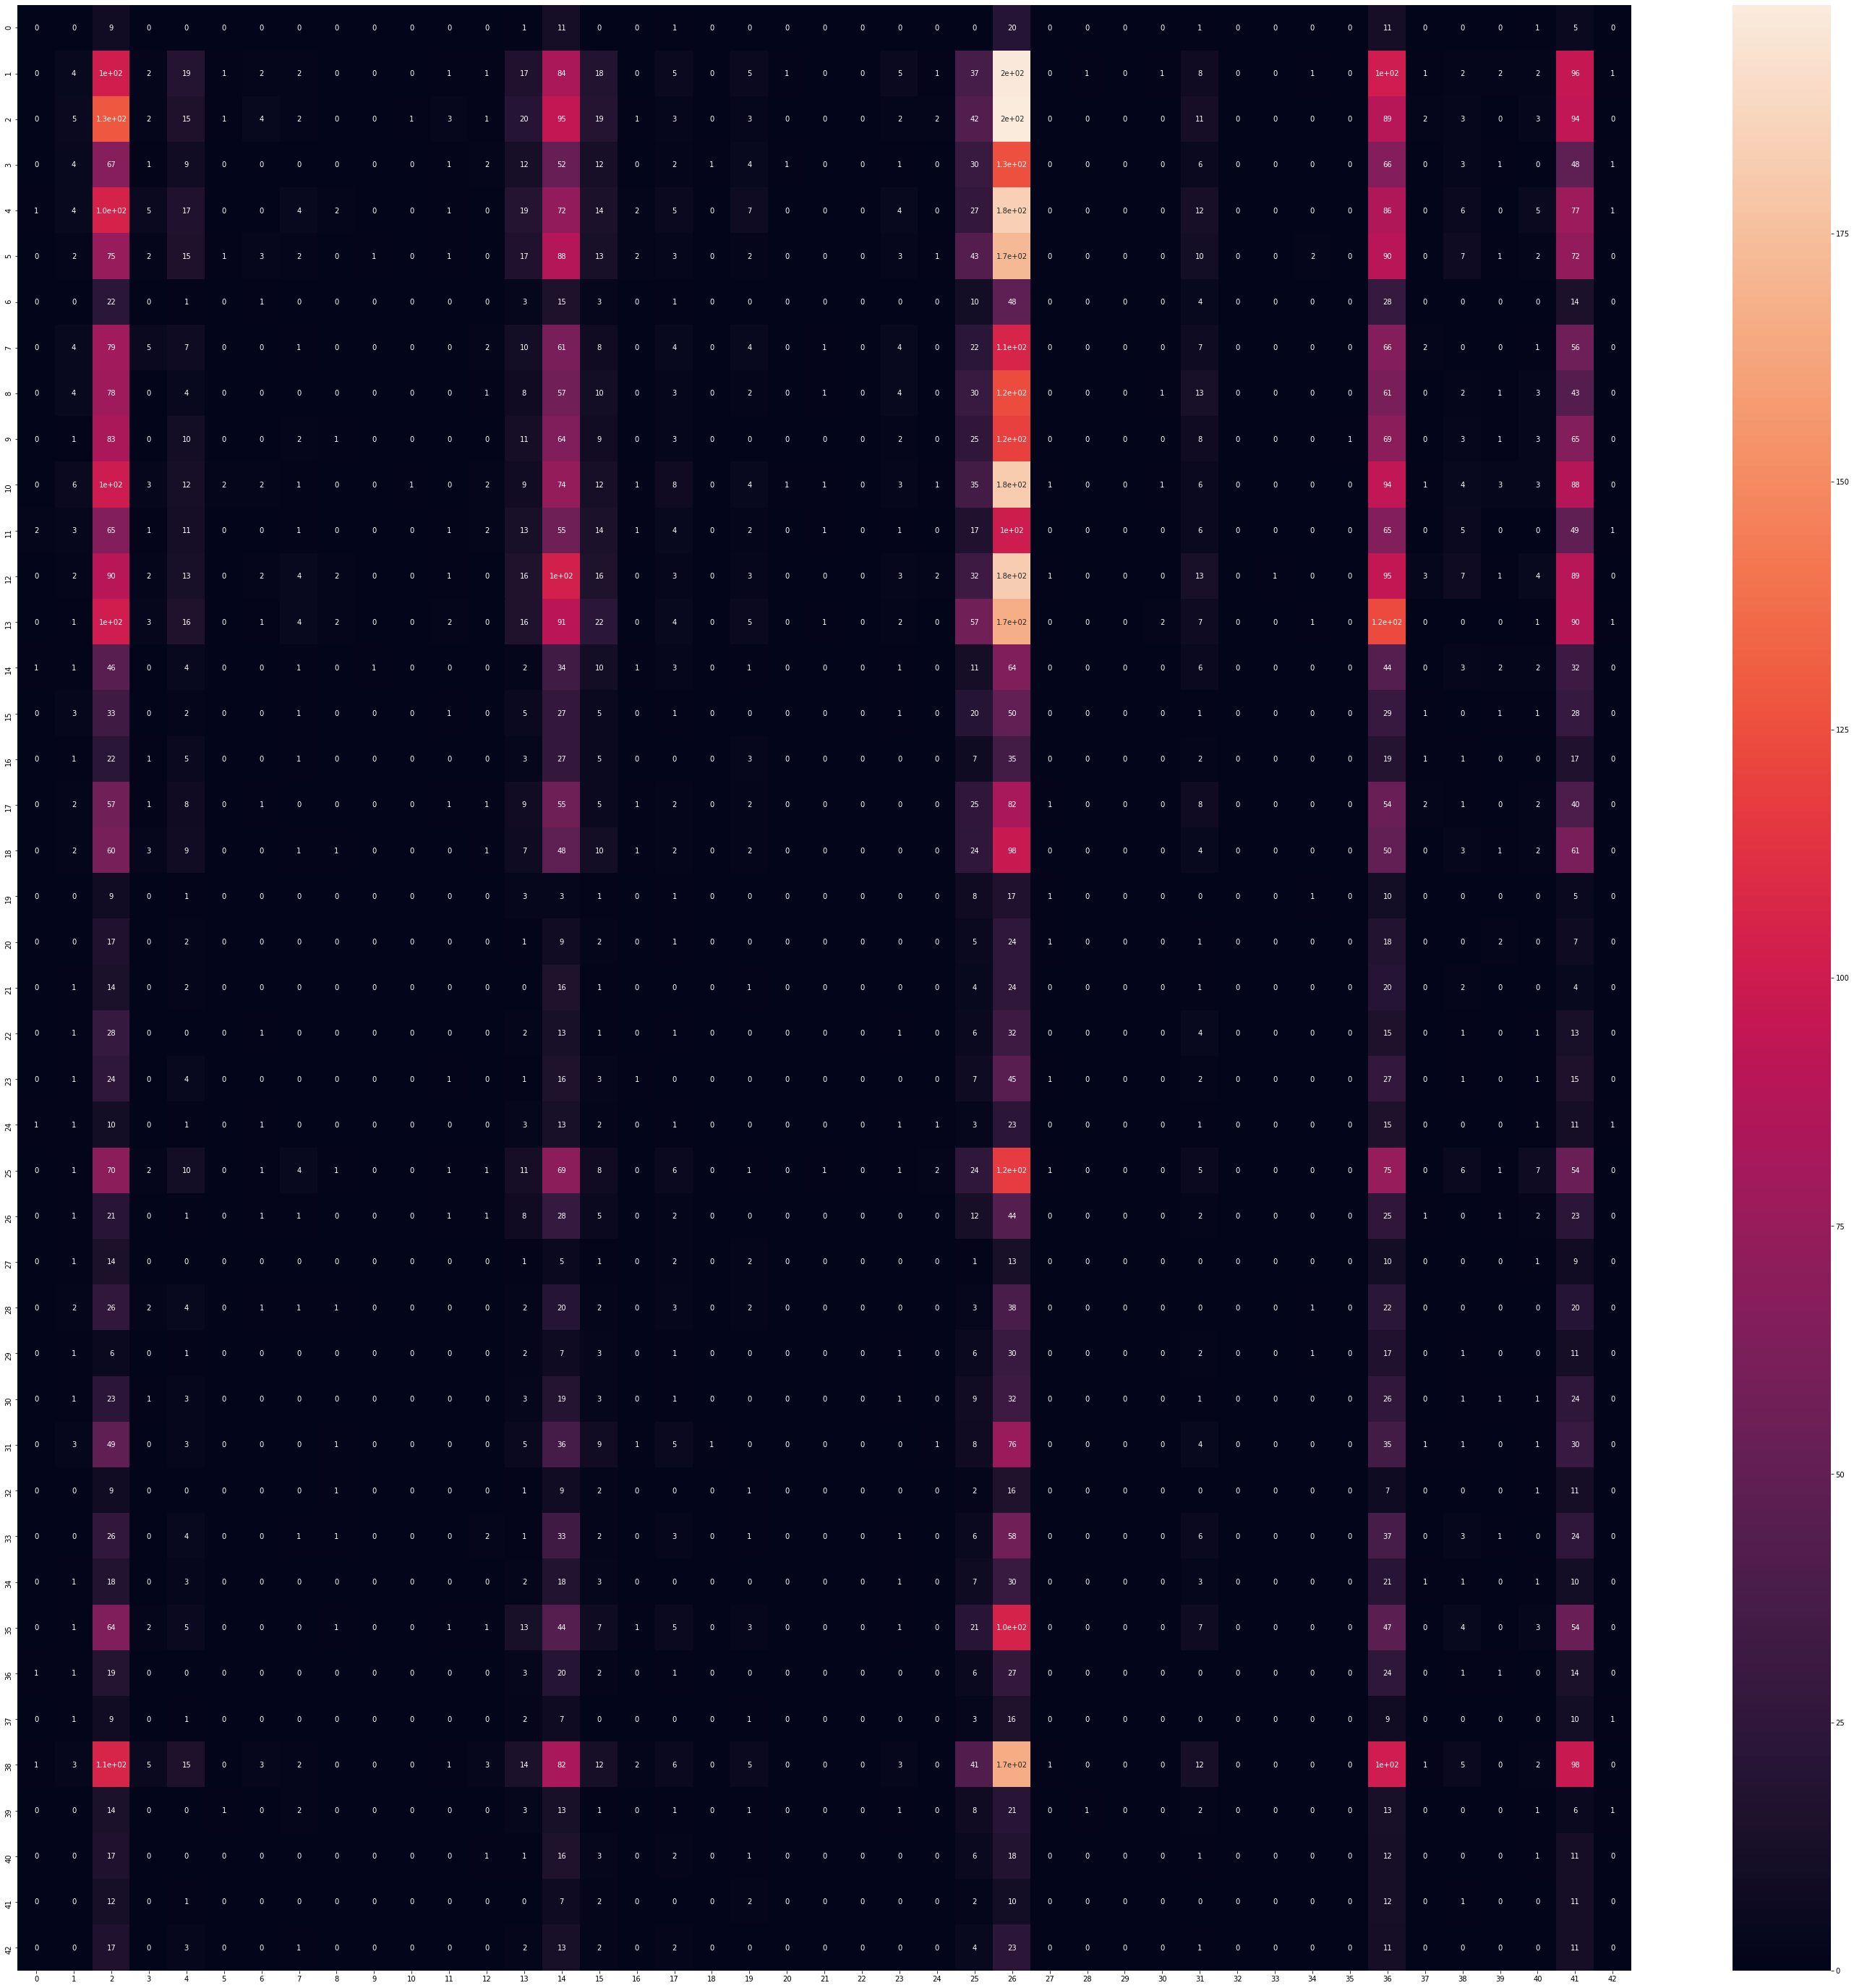

In [ ]:
print('Resultados en set de Test')
ypred = mlp.predict(Xte)
get_metrics(y_test, ypred)

*Evaluamos si la selección de características obtenidas por el codificador del Autoencoder mejoraba su performance, pero este no fue el caso. Visto que en ambos experimentos en los que aplicamos selección de características, la performance cayó significativamente, podríamos decir que el método seleccionado no es bueno o que incluso las características extraídas no son suficientemente descriptivas de la imagen*

#### G. GridSearch con features obtenidas mediante autoencoder (imagen color)
*   Imagen color (3 canales)
*   Todas las observaciones
*   Extracción de features (autoencoders)

In [ ]:
#Features del espacio latente
Xtr_ae = encoder_ae.predict(X_train)
Xval_ae = encoder_ae.predict(X_val)
Xte_ae = encoder_ae.predict(X_test) 

#Flatten features
Xtr = flatten_features(Xtr_ae)
Xval = flatten_features(Xval_ae)
Xte = flatten_features(Xte_ae)

Xtr.shape, Xval.shape, Xte.shape

((34799, 640), (4410, 640), (12630, 640))

In [ ]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(Xtr, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=100, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['ta

In [ ]:
mlp = clf.best_estimator_

Resultados en set de Validación
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        30
           1       0.79      0.89      0.84       240
           2       0.81      0.88      0.84       240
           3       0.86      0.91      0.88       150
           4       0.66      0.84      0.74       210
           5       0.79      0.78      0.78       210
           6       0.82      0.88      0.85        60
           7       0.62      0.71      0.66       150
           8       0.76      0.54      0.63       150
           9       0.92      0.95      0.94       150
          10       0.95      1.00      0.98       210
          11       0.94      0.92      0.93       150
          12       0.97      1.00      0.98       210
          13       0.97      0.96      0.96       240
          14       0.92      0.97      0.94        90
          15       0.92      0.91      0.92        90
          16       0.95      0.87      0.90      

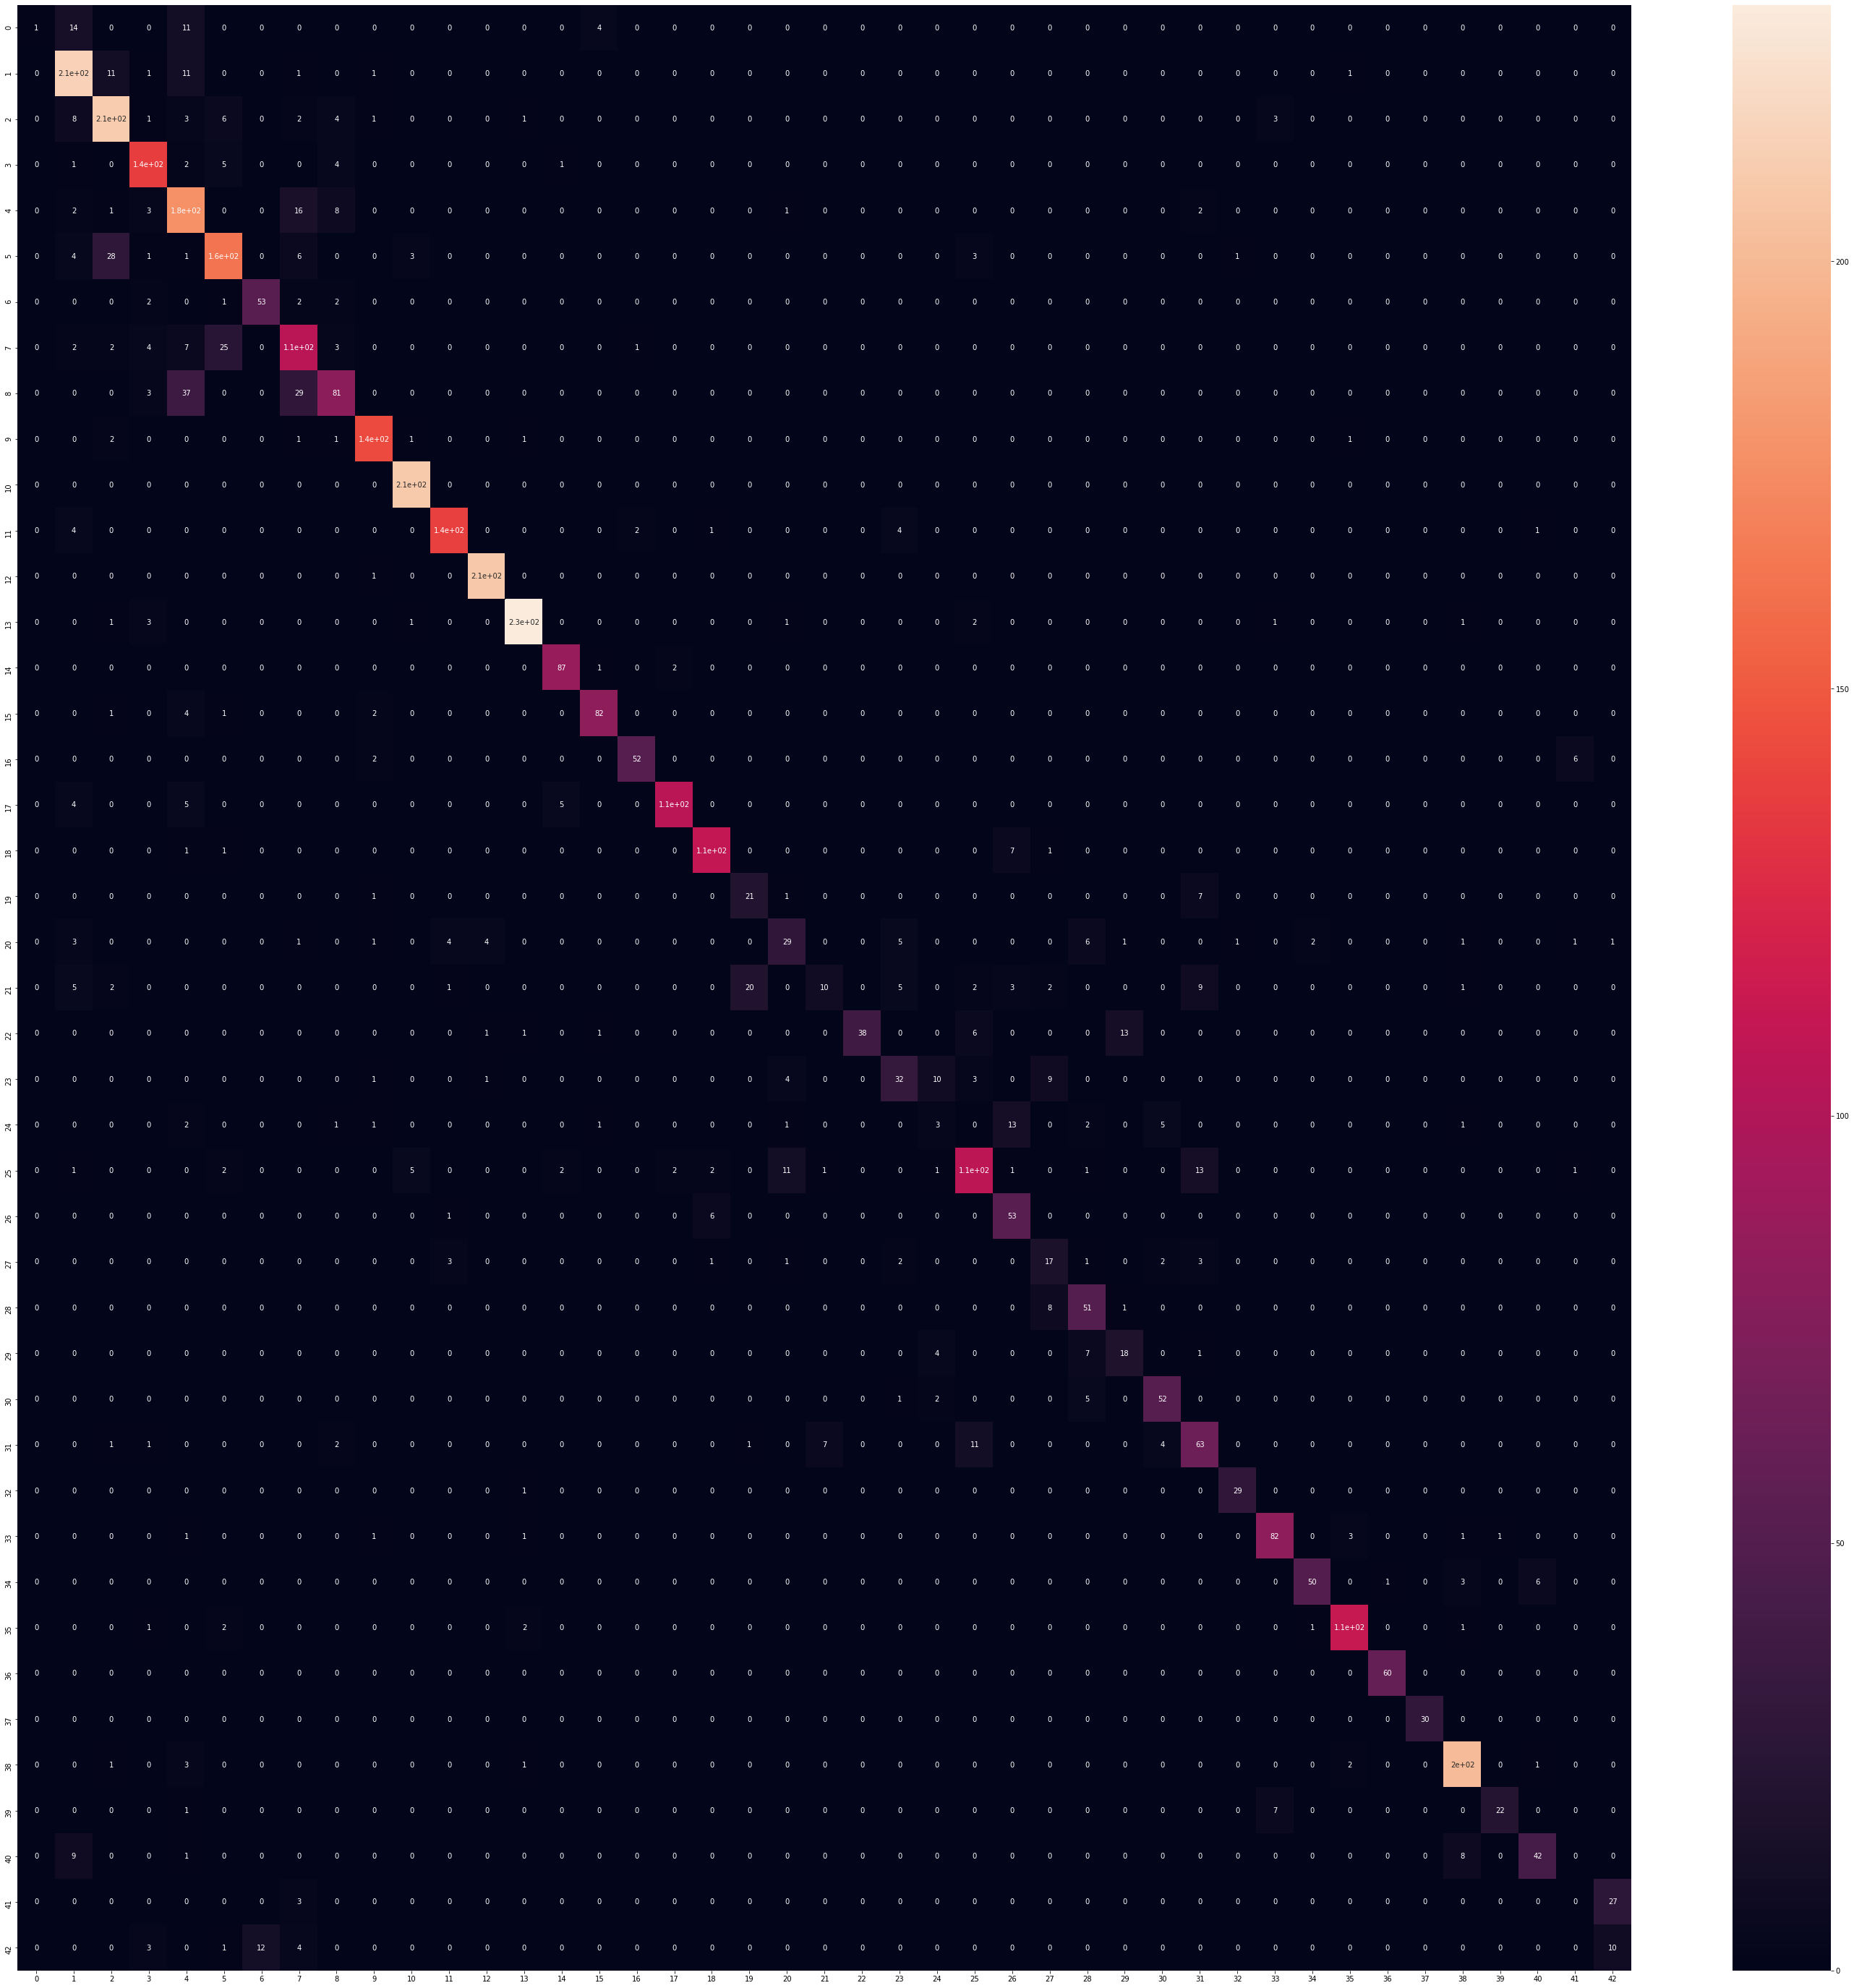

In [ ]:
print('Resultados en set de Validación')
ypred = mlp.predict(Xval)
get_metrics(y_val, ypred)

Resultados en set de Test
              precision    recall  f1-score   support

           0       0.77      0.28      0.41        60
           1       0.71      0.82      0.76       720
           2       0.75      0.86      0.80       750
           3       0.73      0.79      0.76       450
           4       0.73      0.84      0.78       660
           5       0.74      0.77      0.75       630
           6       0.90      0.71      0.80       150
           7       0.76      0.71      0.73       450
           8       0.79      0.72      0.75       450
           9       0.88      0.86      0.87       480
          10       0.93      0.94      0.94       660
          11       0.90      0.85      0.87       420
          12       0.99      0.94      0.96       690
          13       0.94      0.99      0.96       720
          14       0.99      0.97      0.98       270
          15       0.91      0.79      0.85       210
          16       0.96      0.95      0.96       150
 

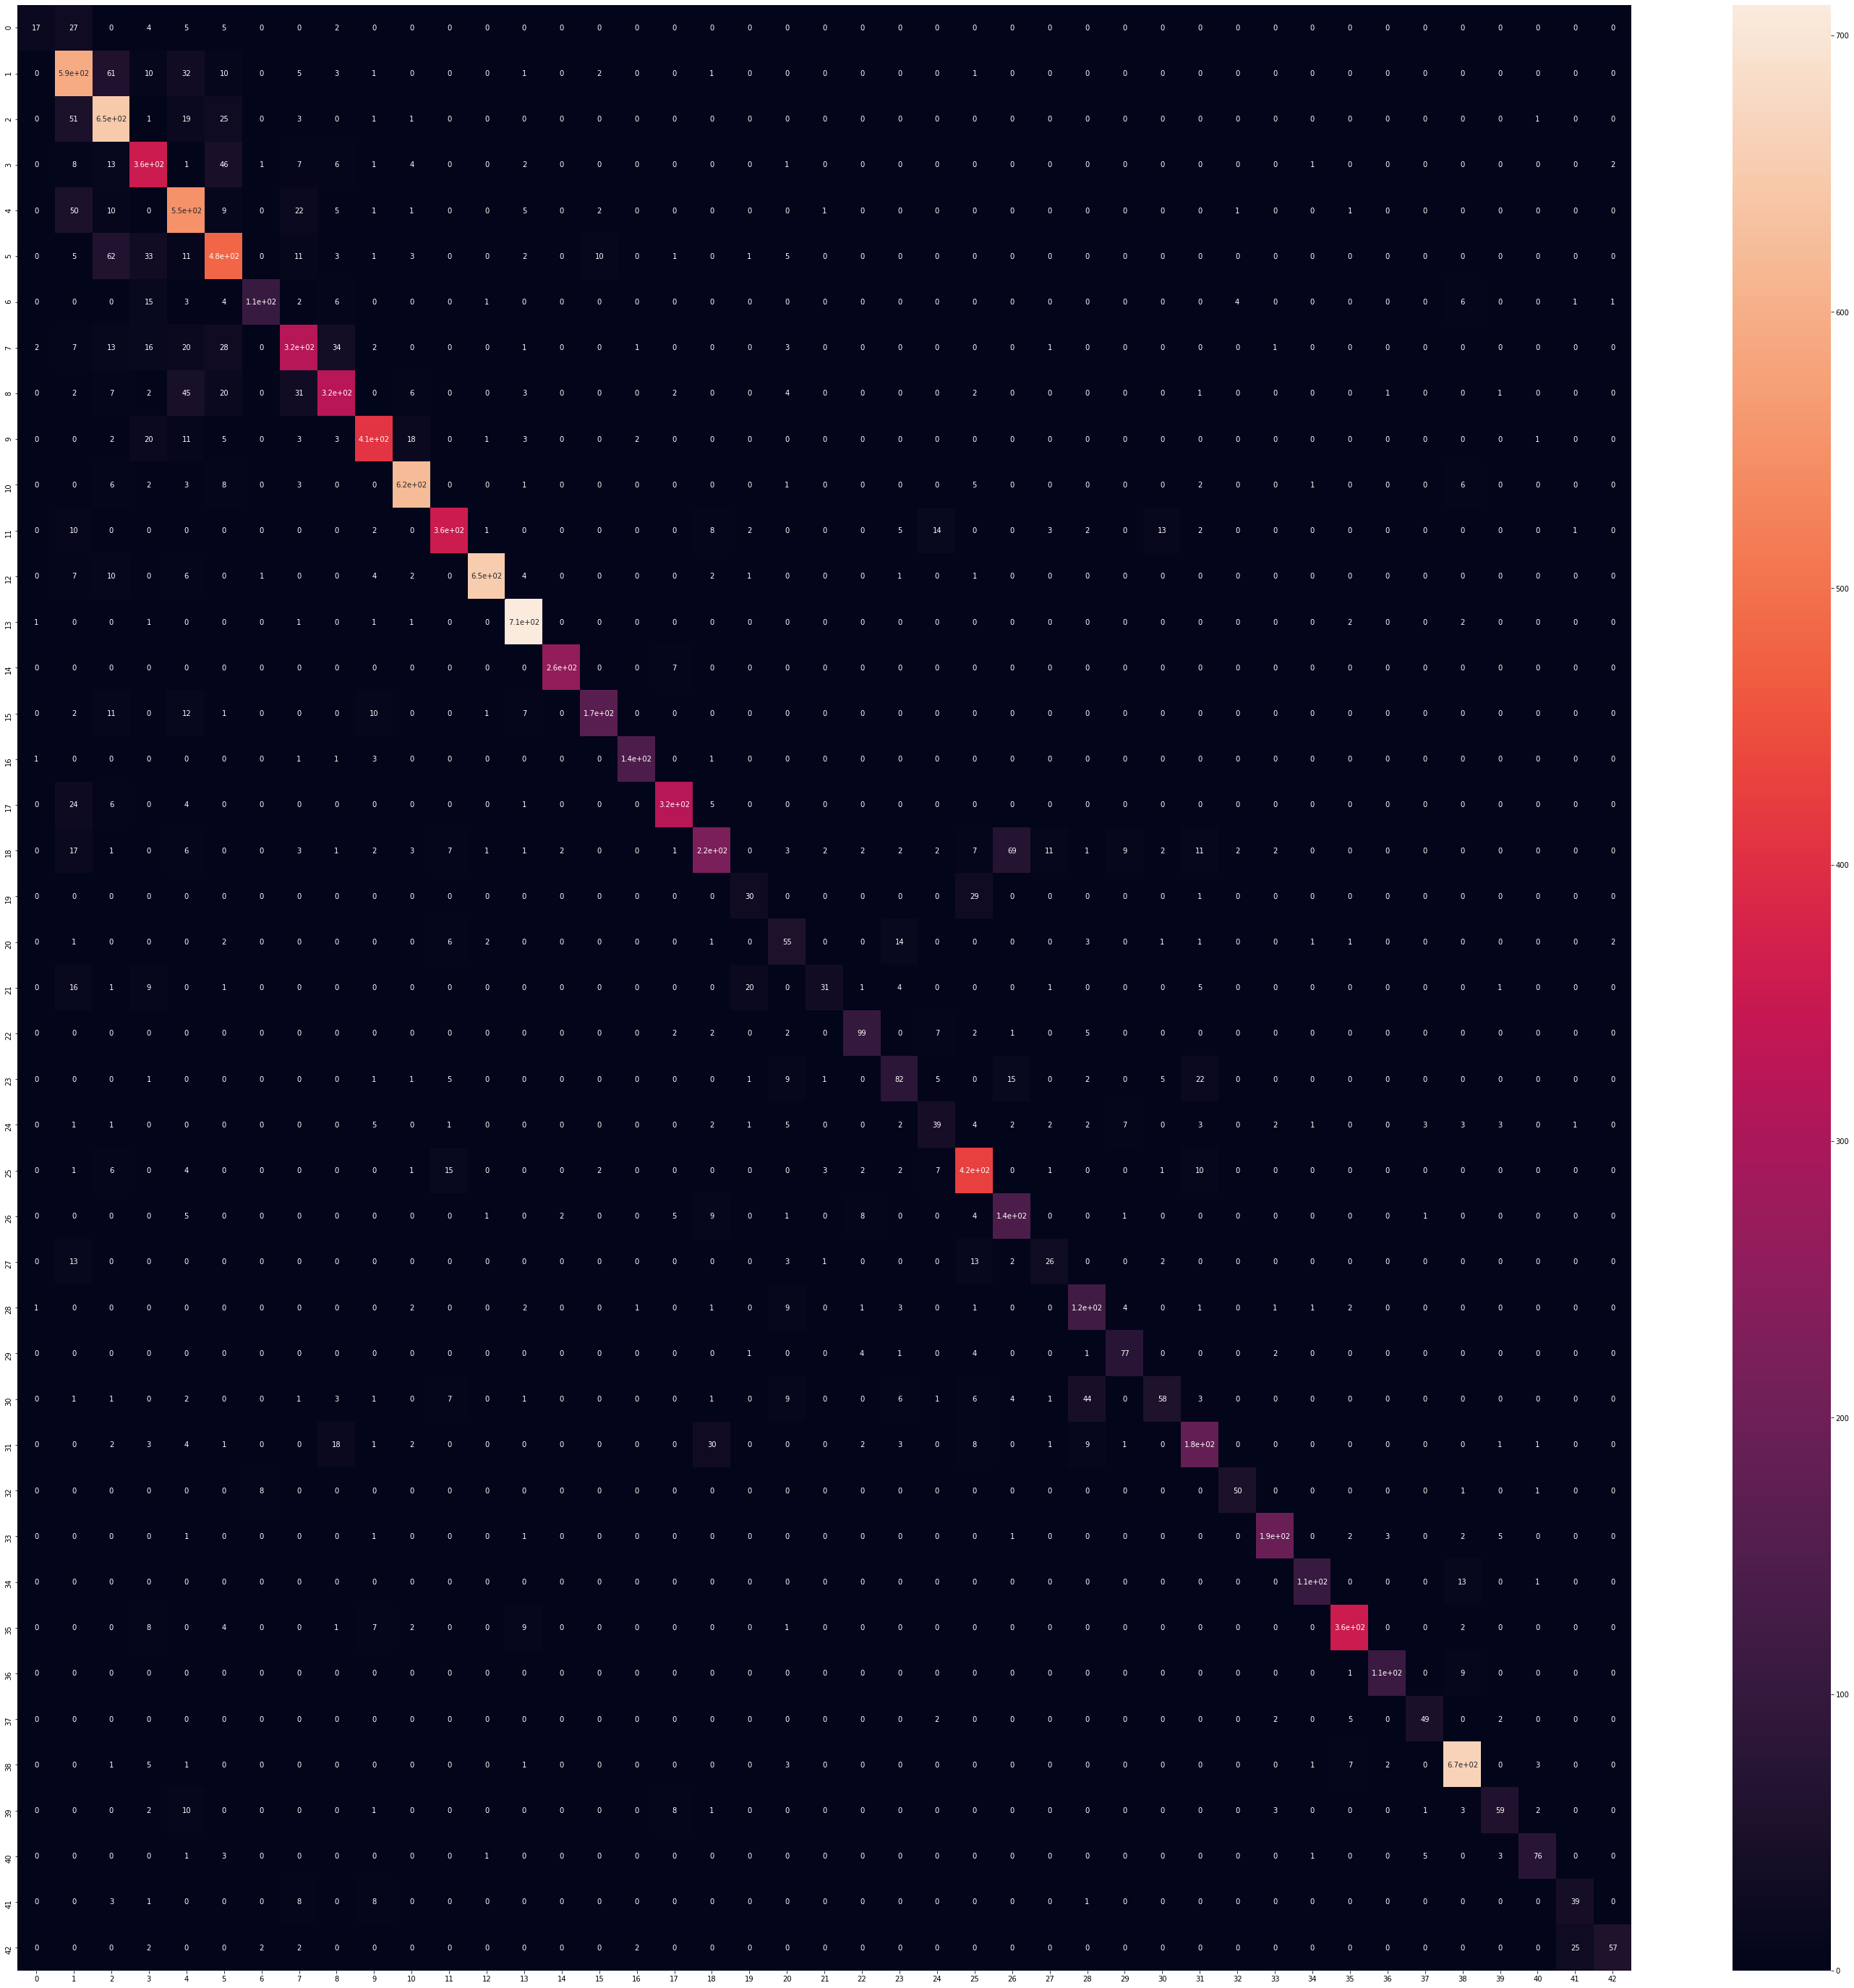

In [ ]:
print('Resultados en set de Test')
ypred = mlp.predict(Xte)
get_metrics(y_test, ypred)

*Finalmente evaluamos si con las caraterísticas obtenidas del Autoencoder, podríamos mejorar la performance del modelo al hacer una búsqueda de los mejores hiperparámetros para el perceptrón multicapa. Los resultados obtenidos son superiores en el experimento G en relación al experimento E, aunque continuan sin detectarse algunas clases en el set de validación.*

*Si bien el mejor resultado lo obtuvimos en el experimento A valiéndonos de todas las imágenes y todos sus píxeles, no descartamos que una mejora en el proceso de extracción de características (mejorando el AutoEncoder o empleando otros métodos) permita obtener un desempeño similar con menor costo computacional. Así mismo, suponemos que los resultados en el experimento A podrían ser superados al hacer la búsqueda de los mejores hiperparámetros.*